In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

In [2]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [3]:
directory = os.path.dirname(os.path.dirname(os.getcwd()))
directory

'/data/user/boiger_r/aerosol'

In [4]:
test_datafile = directory +'/aerosol_data/raw_data_AAE/pre_log_ts-0.2_wl-450-532-630_sc-None_qoi-ScatteringData_09_47/test_dataset.hdf5'




In [5]:
#model_name = 'invertible_model'
#val_model_name = 'forward_model'

In [6]:
#model_dir = directory +'/aerosol_resultsimulated_data/models_overview/models_asha16'

In [7]:
#plot_dir = directory +'/aerosol_results/simulated_data/invertible_model4/plots/model'
#if not os.path.exists(plot_dir):
#    os.makedirs(plot_dir)

In [8]:
#test_datafile = directory +'/aerosol_data/raw_data/raw_data_preprocessed_wo_angles/test_dataset.hdf5'

In [9]:
model_name = 'invertible_model'
val_model_name = 'forward_model'

In [10]:
directory1 = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/'
directory1 = directory1 + 'paper_results_scan_AAE/version4'


In [30]:
plot_dir = directory1 + '/plots/model_1'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
#
model_dir = directory1 +'/model_1'
#if not os.path.exists(model_dir):
#    os.makedirs(model_dir)

In [12]:
model_dir

'/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/paper_results_scan_AAE/version4/model_1'

# Load the model and the data (dvar, qoi) for testing

In [13]:
custom_objects = {'AdjustedRSquared': AdjustedRSquared}

kwargs = {'custom_objects': custom_objects,'compile': False}

surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

In [14]:
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

In [15]:
dvar_test.describe()

V_tot      R_median           GSD             n         k_532  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean    2494.405197      1.325892      1.425071      1.465052      0.062797   
std     1448.337398      0.679264      0.014348      0.077823      0.042165   
min        1.034816      0.150249      1.400004      1.330004      0.000050   
25%     1231.452686      0.740122      1.412740      1.398144      0.028657   
50%     2487.279890      1.326080      1.425043      1.465069      0.057301   
75%     3754.038491      1.914484      1.437421      1.532431      0.089141   
max     4998.589326      2.499893      1.450000      1.599996      0.197673   

                AAE  
count  20000.000000  
mean       4.024817  
std        1.732465  
min        1.000217  
25%        2.532972  
50%        4.027542  
75%        5.533118  
max        6.999821

In [16]:
qoi_test

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
0       -15.335839   -15.710499   -16.106760   -16.512932   -16.917604   
1       -15.861208   -16.054745   -16.269814   -16.502406   -16.748644   
2       -15.147923   -15.755260   -16.336563   -16.855195   -17.295654   
3       -14.785228   -14.807387   -14.833391   -14.863078   -14.896381   
4       -15.052213   -15.223601   -15.413860   -15.619505   -15.837136   
...            ...          ...          ...          ...          ...   
19995   -14.699988   -15.128183   -15.575655   -16.027067   -16.466732   
19996   -15.279204   -15.826173   -16.367481   -16.872268   -17.316948   
19997   -15.210684   -15.253267   -15.302642   -15.358318   -15.419911   
19998   -14.759481   -15.132167   -15.526096   -15.927806   -16.323326   
19999   -15.654047   -16.257151   -16.831466   -17.344860   -17.786594   

       P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
0        -17.308922    -17.680316    -18.019023    -18.344924    -18.592217   
1        -17.005046    -17.268275    -17.534643    -17.813854    -18.065317   
2        -17.645769    -17.942647    -18.192589    -18.422442    -18.600190   
3        -14.933183    -14.973363    -15.016754    -15.065283    -15.112769   
4        -16.063892    -16.297067    -16.533823    -16.783978    -17.009474   
...             ...           ...           ...           ...           ...   
19995    -16.878259    -17.255906    -17.586164    -17.895538    -18.117987   
19996    -17.682799    -17.987406    -18.233952    -18.442047    -18.611079   
19997    -15.486930    -15.558937    -15.635484    -15.719857    -15.800515   
19998    -16.698843    -17.044336    -17.347728    -17.616798    -17.830231   
19999    -18.142746    -18.448720    -18.709564    -18.950859    -19.135378   

       ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
0      ...       0.085856       0.057418       0.034263       0.017741   
1      ...      -0.018854      -0.007165       0.002785       0.010550   
2      ...       0.016375       0.015044       0.013846       0.012706   
3      ...      -0.013011      -0.012847      -0.012280      -0.011386   
4      ...      -0.315090      -0.308050      -0.294080      -0.272370   
...    ...            ...            ...            ...            ...   
19995  ...       0.067438       0.032666       0.004423      -0.015897   
19996  ...       0.207710       0.199470       0.183630       0.158070   
19997  ...      -0.198070      -0.184590      -0.168680      -0.150830   
19998  ...      -0.207990      -0.223080      -0.241280      -0.259670   
19999  ...      -0.015022      -0.018834      -0.019544      -0.016674   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.009332       0.010643       0.022662       0.043431   
1           0.015878       0.018746       0.019358       0.018103   
2           0.011556       0.010341       0.009030       0.007616   
3          -0.010240      -0.008920      -0.007501      -0.006055   
4          -0.242960      -0.207220      -0.167870      -0.128450   
...              ...            ...            ...            ...   
19995      -0.026660      -0.025800      -0.011231       0.016919   
19996       0.124190       0.085644       0.045158       0.005981   
19997      -0.131620      -0.111700      -0.091799      -0.072599   
19998      -0.274880      -0.283120      -0.280240      -0.262590   
19999      -0.010206      -0.000796       0.010055       0.020072   

       P12_0.630_174  P12_0.630_175  
0           0.064713       0.073603  
1           0.015491       0.012088  
2           0.006125       0.004613  
3          -0.004652      -0.003351  
4          -0.092306      -0.061773  
...              ...            ...  
19995       0.051331       0.075070  
19996      -0.027905      -0.049690  
19997      -0.054749      -0.038806  
19998      -0.228760      -0.181380  
19999       0.026723       0.0281

In [17]:
qoi_test

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
0       -15.335839   -15.710499   -16.106760   -16.512932   -16.917604   
1       -15.861208   -16.054745   -16.269814   -16.502406   -16.748644   
2       -15.147923   -15.755260   -16.336563   -16.855195   -17.295654   
3       -14.785228   -14.807387   -14.833391   -14.863078   -14.896381   
4       -15.052213   -15.223601   -15.413860   -15.619505   -15.837136   
...            ...          ...          ...          ...          ...   
19995   -14.699988   -15.128183   -15.575655   -16.027067   -16.466732   
19996   -15.279204   -15.826173   -16.367481   -16.872268   -17.316948   
19997   -15.210684   -15.253267   -15.302642   -15.358318   -15.419911   
19998   -14.759481   -15.132167   -15.526096   -15.927806   -16.323326   
19999   -15.654047   -16.257151   -16.831466   -17.344860   -17.786594   

       P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
0        -17.308922    -17.680316    -18.019023    -18.344924    -18.592217   
1        -17.005046    -17.268275    -17.534643    -17.813854    -18.065317   
2        -17.645769    -17.942647    -18.192589    -18.422442    -18.600190   
3        -14.933183    -14.973363    -15.016754    -15.065283    -15.112769   
4        -16.063892    -16.297067    -16.533823    -16.783978    -17.009474   
...             ...           ...           ...           ...           ...   
19995    -16.878259    -17.255906    -17.586164    -17.895538    -18.117987   
19996    -17.682799    -17.987406    -18.233952    -18.442047    -18.611079   
19997    -15.486930    -15.558937    -15.635484    -15.719857    -15.800515   
19998    -16.698843    -17.044336    -17.347728    -17.616798    -17.830231   
19999    -18.142746    -18.448720    -18.709564    -18.950859    -19.135378   

       ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
0      ...       0.085856       0.057418       0.034263       0.017741   
1      ...      -0.018854      -0.007165       0.002785       0.010550   
2      ...       0.016375       0.015044       0.013846       0.012706   
3      ...      -0.013011      -0.012847      -0.012280      -0.011386   
4      ...      -0.315090      -0.308050      -0.294080      -0.272370   
...    ...            ...            ...            ...            ...   
19995  ...       0.067438       0.032666       0.004423      -0.015897   
19996  ...       0.207710       0.199470       0.183630       0.158070   
19997  ...      -0.198070      -0.184590      -0.168680      -0.150830   
19998  ...      -0.207990      -0.223080      -0.241280      -0.259670   
19999  ...      -0.015022      -0.018834      -0.019544      -0.016674   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.009332       0.010643       0.022662       0.043431   
1           0.015878       0.018746       0.019358       0.018103   
2           0.011556       0.010341       0.009030       0.007616   
3          -0.010240      -0.008920      -0.007501      -0.006055   
4          -0.242960      -0.207220      -0.167870      -0.128450   
...              ...            ...            ...            ...   
19995      -0.026660      -0.025800      -0.011231       0.016919   
19996       0.124190       0.085644       0.045158       0.005981   
19997      -0.131620      -0.111700      -0.091799      -0.072599   
19998      -0.274880      -0.283120      -0.280240      -0.262590   
19999      -0.010206      -0.000796       0.010055       0.020072   

       P12_0.630_174  P12_0.630_175  
0           0.064713       0.073603  
1           0.015491       0.012088  
2           0.006125       0.004613  
3          -0.004652      -0.003351  
4          -0.092306      -0.061773  
...              ...            ...  
19995       0.051331       0.075070  
19996      -0.027905      -0.049690  
19997      -0.054749      -0.038806  
19998      -0.228760      -0.181380  
19999       0.026723       0.0281

In [18]:
qoi_test.describe()

P11_0.450_5   P11_0.450_6   P11_0.450_7   P11_0.450_8   P11_0.450_9  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean     -15.742746    -16.094201    -16.442494    -16.772860    -17.079866   
std        1.073875      1.157786      1.258346      1.355384      1.440468   
min      -23.566466    -24.189322    -24.769392    -25.274232    -25.700196   
25%      -16.218225    -16.657411    -17.130092    -17.562454    -17.955281   
50%      -15.519616    -15.919122    -16.302343    -16.680092    -17.043995   
75%      -14.970915    -15.237059    -15.479906    -15.717007    -15.946119   
max      -14.028333    -14.093955    -14.168962    -14.252358    -14.314737   

       P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean     -17.356470    -17.611971    -17.844283    -18.066719    -18.249746   
std        1.506616      1.561926      1.605937      1.642662      1.666739   
min      -26.038831    -26.331429    -26.582440    -26.811373    -26.992277   
25%      -18.286806    -18.583594    -18.848530    -19.091739    -19.282939   
50%      -17.388743    -17.696835    -17.972763    -18.231094    -18.431262   
75%      -16.179354    -16.393540    -16.610451    -16.831007    -17.033106   
max      -14.379052    -14.421966    -14.467938    -14.518728    -14.567707   

       ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
count  ...   20000.000000   20000.000000   20000.000000   20000.000000   
mean   ...      -0.138039      -0.138557      -0.137163      -0.133660   
std    ...       0.208743       0.197549       0.184796       0.170009   
min    ...      -0.638520      -0.619900      -0.600190      -0.569580   
25%    ...      -0.289543      -0.282108      -0.267910      -0.250403   
50%    ...      -0.090586      -0.092877      -0.095398      -0.097207   
75%    ...       0.002262      -0.003894      -0.009098      -0.012219   
max    ...       0.496140       0.490050       0.501860       0.485990   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
count   20000.000000   20000.000000   20000.000000   20000.000000   
mean       -0.127551      -0.118310      -0.105522      -0.089081   
std         0.153548       0.136131       0.118545       0.102128   
min        -0.526350      -0.476370      -0.418490      -0.348680   
25%        -0.231620      -0.211855      -0.190252      -0.162995   
50%        -0.096530      -0.092647      -0.084806      -0.072380   
75%        -0.012860      -0.008989      -0.006443      -0.003348   
max         0.445730       0.388640       0.330170       0.256370   

       P12_0.630_174  P12_0.630_175  
count   20000.000000   20000.000000  
mean       -0.069797      -0.049623  
std         0.088062       0.076157  
min        -0.331050      -0.319480  
25%        -0.132433      -0.099657  
50%        -0.057267      -0.041920  
75%         0.000459       0.002745  
max         0.167390       0.120910  

[8 rows x 960 columns]

In [19]:
#qoi_test = qoi_test.iloc[0:5]
#dvar_test = dvar_test.iloc[0:5]

In [20]:
qoi_columns = qoi_test.columns
dvar_columns = dvar_test.columns

In [21]:
qoi_test_plot = qoi_test.copy()

In [22]:
dvar_test

V_tot  R_median       GSD         n     k_532       AAE
0      2315.678911  1.360143  1.422027  1.345160  0.060143  5.833945
1      1121.450456  0.871451  1.422156  1.560918  0.172217  1.027340
2      4962.553150  2.033473  1.405489  1.556752  0.179643  1.194336
3      4874.291655  0.258148  1.404925  1.331706  0.039514  4.331665
4      2536.972303  0.806500  1.444872  1.436442  0.118185  3.215479
...            ...       ...       ...       ...       ...       ...
19995  4764.529527  1.494872  1.414259  1.333477  0.047427  4.642539
19996  3534.192530  1.835515  1.405211  1.468337  0.012928  5.740662
19997  2015.697397  0.385029  1.430910  1.390257  0.042194  3.183546
19998  3989.475902  1.355483  1.409619  1.563611  0.013500  4.484978
19999  3102.600374  2.073354  1.426555  1.338385  0.098061  1.239737

[20000 rows x 6 columns]

# Prediction

## Forward Prediction

In [23]:
import time
start = time.time()
qoi_pred_fw = surr.predict(dvar_test.values)
end = time.time()
time = (end-start)/len(dvar_test)
time

0.00032813527584075927

In [24]:
qoi_columns

Index(['P11_0.450_5', 'P11_0.450_6', 'P11_0.450_7', 'P11_0.450_8',
       'P11_0.450_9', 'P11_0.450_10', 'P11_0.450_11', 'P11_0.450_12',
       'P11_0.450_13', 'P11_0.450_14',
       ...
       'P12_0.630_166', 'P12_0.630_167', 'P12_0.630_168', 'P12_0.630_169',
       'P12_0.630_170', 'P12_0.630_171', 'P12_0.630_172', 'P12_0.630_173',
       'P12_0.630_174', 'P12_0.630_175'],
      dtype='object', length=960)

In [25]:
qoi_pred_fw.shape

(20000, 960)

In [26]:
qoi_pred_fw = pd.DataFrame(data=qoi_pred_fw, columns=qoi_columns)
qoi_pred_fw

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
0       -15.304920   -15.699573   -16.111934   -16.567607   -16.898223   
1       -15.917886   -16.015811   -16.207753   -16.501228   -16.709774   
2       -14.986966   -15.652786   -16.293428   -16.888801   -17.101274   
3       -14.940397   -14.806516   -14.839033   -14.801359   -14.821924   
4       -15.065255   -15.172484   -15.444049   -15.598841   -15.847268   
...            ...          ...          ...          ...          ...   
19995   -14.681847   -15.117872   -15.592381   -16.055881   -16.505272   
19996   -15.344723   -15.845027   -16.343904   -16.845787   -17.276592   
19997   -15.272488   -15.332228   -15.332621   -15.323788   -15.461951   
19998   -14.863902   -15.118849   -15.510858   -15.912766   -16.279640   
19999   -15.707540   -16.221729   -16.761078   -17.310657   -17.732372   

       P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
0        -17.268612    -17.648149    -18.005195    -18.346743    -18.610992   
1        -16.977144    -17.338148    -17.509481    -17.797359    -18.031604   
2        -17.615034    -17.909612    -18.184446    -18.402876    -18.461830   
3        -14.942841    -15.025051    -15.070869    -15.109810    -15.145710   
4        -15.987309    -16.307399    -16.524784    -16.702427    -16.999551   
...             ...           ...           ...           ...           ...   
19995    -16.833339    -17.252019    -17.569548    -17.872826    -18.118324   
19996    -17.760299    -18.087385    -18.217031    -18.525868    -18.617631   
19997    -15.442641    -15.585345    -15.665549    -15.714562    -15.882617   
19998    -16.712897    -17.038936    -17.293921    -17.640449    -17.750344   
19999    -18.149625    -18.411085    -18.658002    -18.995438    -19.144735   

       ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
0      ...       0.087355       0.064713       0.043786       0.023908   
1      ...      -0.015393      -0.009728       0.025457       0.025454   
2      ...       0.040985       0.015931       0.025347       0.022454   
3      ...      -0.025685      -0.030584      -0.029195      -0.013063   
4      ...      -0.313812      -0.299860      -0.286463      -0.268825   
...    ...            ...            ...            ...            ...   
19995  ...       0.077786       0.042974       0.015494       0.003762   
19996  ...       0.228935       0.204503       0.191459       0.173788   
19997  ...      -0.219888      -0.201190      -0.180941      -0.162850   
19998  ...      -0.198331      -0.215577      -0.230052      -0.251268   
19999  ...      -0.011715      -0.013113      -0.006650      -0.022165   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.016696       0.022375       0.035849       0.046782   
1           0.018074       0.023925       0.031557       0.016797   
2           0.022147       0.019440       0.021234       0.013668   
3          -0.020276      -0.017625      -0.015845      -0.008560   
4          -0.233521      -0.198389      -0.157922      -0.117845   
...              ...            ...            ...            ...   
19995      -0.013513      -0.005811       0.006860       0.036333   
19996       0.133913       0.094468       0.054393       0.013348   
19997      -0.137984      -0.109857      -0.102687      -0.076557   
19998      -0.265595      -0.274232      -0.271882      -0.261549   
19999      -0.014784      -0.004173       0.008435       0.018182   

       P12_0.630_174  P12_0.630_175  
0           0.067122       0.073042  
1           0.005555      -0.001466  
2           0.010565       0.003424  
3          -0.002225      -0.003871  
4          -0.084721      -0.054954  
...              ...            ...  
19995       0.068755       0.091031  
19996      -0.026649      -0.042734  
19997      -0.057738      -0.039956  
19998      -0.226244      -0.182749  
19999       0.028679       0.0322

In [27]:
np.min(np.abs(qoi_pred_fw.mean()))

0.00023594465266778083

In [28]:
qoi_pred_plot_fw = qoi_pred_fw.copy()
#qoi_pred_plot_fw

## Inverse prediction

In [31]:
import time
n_tries = 32
start = time.time()
dvar_pred_iv = surr.sample_n_tries(qoi_test.values, batch_size=256, n_tries=n_tries)
end = time.time()
iv_time = (end-start)/len(qoi_test)
iv_time

0.0145560564160347

In [32]:
dvar_columns

Index(['V_tot', 'R_median', 'GSD', 'n', 'k_532', 'AAE'], dtype='object')

In [33]:
dvar_pred_iv = pd.DataFrame(data=dvar_pred_iv, columns=dvar_columns)
dvar_pred_iv

V_tot  R_median       GSD         n     k_532       AAE
0      2280.158294  1.352791  1.419626  1.345751  0.060396  5.821619
1      1145.982054  0.877115  1.426164  1.559857  0.170305  1.103457
2      4865.498866  2.046812  1.409467  1.553362  0.175489  1.156135
3      5004.046128  0.269412  1.410175  1.332225  0.037740  4.459900
4      2489.960993  0.796391  1.442611  1.435082  0.118975  3.235074
...            ...       ...       ...       ...       ...       ...
19995  4737.545261  1.480661  1.413731  1.332956  0.047031  4.648382
19996  3556.646428  1.828327  1.403639  1.469411  0.013076  5.723170
19997  2052.622642  0.394605  1.430887  1.389195  0.039715  3.175218
19998  3992.841393  1.338555  1.406980  1.561546  0.014549  4.482934
19999  3092.336503  2.088593  1.427896  1.336947  0.098685  1.209632

[20000 rows x 6 columns]

In [34]:
dvar_pred_iv.describe()

V_tot      R_median           GSD             n         k_532  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean    2505.317729      1.327093      1.425018      1.465027      0.062844   
std     1447.966210      0.678145      0.013942      0.078120      0.041896   
min     -148.438971      0.104185      1.399830      1.324974     -0.004162   
25%     1242.341298      0.738745      1.412847      1.397841      0.029015   
50%     2497.741779      1.328155      1.424966      1.465302      0.057506   
75%     3766.641162      1.913106      1.437366      1.532818      0.089043   
max     5178.232097      2.557820      1.451759      1.611233      0.202301   

                AAE  
count  20000.000000  
mean       4.026294  
std        1.723801  
min        0.756079  
25%        2.537169  
50%        4.031489  
75%        5.528256  
max        7.353857

# Calculate metrics

## R2

Use either R2 or adjusted R2

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$


adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$


In [35]:
#metric_fw = AdjustedRSquaredSeparated(qoi_test.shape[0], qoi_test.shape[1])
metric_fw = RSquaredSeparated()

r2_adj_fw = metric_fw.call(qoi_test.values, qoi_pred_fw.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=qoi_columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=4)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T
print('Forward model: ','R2_min = ', min(r2_adj_fw.min()),';  R2_max = ', max(r2_adj_fw.max()))

r2_adj_fw

Forward model:  R2_min =  0.9726 ;  R2_max =  0.9991


P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
0       0.9943       0.9972       0.9977       0.9971       0.9983   

   P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  ...  \
0        0.9968        0.9979         0.998         0.998        0.9985  ...   

   P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  P12_0.630_170  \
0         0.9921         0.9899         0.9901         0.9905         0.9904   

   P12_0.630_171  P12_0.630_172  P12_0.630_173  P12_0.630_174  P12_0.630_175  
0         0.9899         0.9841         0.9827         0.9836         0.9822  

[1 rows x 960 columns]

In [36]:
r2_adj_fw.mean(axis = 1)

0    0.997205
dtype: float64

In [37]:
r2_fw_sorted = r2_adj_fw.sort_values(by=r2_adj_fw.index[0], axis = 1,ascending=True)

In [38]:
r2_fw_sorted

P12_0.630_149  P11_0.450_22  P12_0.450_175  P12_0.450_174  P12_0.532_174  \
0         0.9726        0.9744         0.9745         0.9809          0.981   

   P12_0.630_175  P12_0.630_173  P12_0.630_174  P12_0.630_172  P12_0.450_173  \
0         0.9822         0.9827         0.9836         0.9841         0.9849   

   ...  P11_0.532_43  P11_0.532_41  P11_0.630_103  P11_0.532_53  P11_0.532_40  \
0  ...        0.9991        0.9991         0.9991        0.9991        0.9991   

   P11_0.450_63  P11_0.630_71  P11_0.532_77  P11_0.532_61  P11_0.532_63  
0        0.9991        0.9991        0.9991        0.9991        0.9991  

[1 rows x 960 columns]

In [39]:
#np.mean(r2_fw_sorted.drop(['P12_0.450_0','P12_0.532_0','P12_0.630_0'],axis =1).mean())

In [40]:
#metric_iv = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])
metric_iv = RSquaredSeparated()

r2_adj_iv = metric_iv.call(dvar_test.values, dvar_pred_iv.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=dvar_columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T
print('Inverse model: ','R2_min = ', min(r2_adj_iv.min()),';  R2_max = ', max(r2_adj_iv.max()))

r2_adj_iv

Inverse model:  R2_min =  0.96 ;  R2_max =  1.0


V_tot  R_median   GSD    n  k_532   AAE
0    1.0       1.0  0.96  1.0    1.0  0.98

In [41]:
np.mean(r2_adj_iv, axis = 1)

0    0.99
dtype: float64

# Relative and absolute error

rel_error = $\frac{y_{true}-y_{pred}}{y_{true}}$

absolute_error = $|y_{true}-y_{pred}|$

be careful, if $y_{true}$ is very small


In [42]:
abs_error_fw = np.abs( (qoi_test) - (qoi_pred_fw))
abs_error_fw

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
0         0.030920     0.010926     0.005174     0.054675     0.019381   
1         0.056678     0.038935     0.062061     0.001178     0.038870   
2         0.160957     0.102474     0.043135     0.033606     0.194380   
3         0.155168     0.000871     0.005642     0.061719     0.074457   
4         0.013041     0.051116     0.030188     0.020664     0.010132   
...            ...          ...          ...          ...          ...   
19995     0.018141     0.010311     0.016725     0.028814     0.038541   
19996     0.065519     0.018855     0.023576     0.026481     0.040356   
19997     0.061803     0.078961     0.029978     0.034530     0.042040   
19998     0.104422     0.013318     0.015237     0.015040     0.043686   
19999     0.053493     0.035422     0.070388     0.034202     0.054222   

       P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
0          0.040310      0.032167      0.013828      0.001819      0.018775   
1          0.027902      0.069873      0.025162      0.016496      0.033713   
2          0.030735      0.033035      0.008143      0.019566      0.138360   
3          0.009658      0.051688      0.054115      0.044527      0.032941   
4          0.076583      0.010332      0.009039      0.081551      0.009924   
...             ...           ...           ...           ...           ...   
19995      0.044921      0.003888      0.016616      0.022712      0.000337   
19996      0.077500      0.099979      0.016922      0.083821      0.006552   
19997      0.044289      0.026408      0.030065      0.005295      0.082102   
19998      0.014054      0.005400      0.053807      0.023652      0.079887   
19999      0.006879      0.037635      0.051561      0.044579      0.009356   

       ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
0      ...       0.001499       0.007295       0.009523       0.006167   
1      ...       0.003461       0.002563       0.022671       0.014904   
2      ...       0.024610       0.000887       0.011501       0.009748   
3      ...       0.012674       0.017737       0.016915       0.001677   
4      ...       0.001278       0.008190       0.007617       0.003545   
...    ...            ...            ...            ...            ...   
19995  ...       0.010348       0.010308       0.011071       0.019659   
19996  ...       0.021225       0.005033       0.007829       0.015718   
19997  ...       0.021818       0.016600       0.012261       0.012020   
19998  ...       0.009659       0.007503       0.011228       0.008402   
19999  ...       0.003307       0.005721       0.012894       0.005491   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.007364       0.011732       0.013187       0.003351   
1           0.002196       0.005179       0.012199       0.001306   
2           0.010591       0.009099       0.012205       0.006052   
3           0.010036       0.008706       0.008344       0.002505   
4           0.009439       0.008831       0.009948       0.010605   
...              ...            ...            ...            ...   
19995       0.013147       0.019989       0.018091       0.019414   
19996       0.009723       0.008824       0.009235       0.007367   
19997       0.006364       0.001843       0.010888       0.003958   
19998       0.009285       0.008888       0.008358       0.001041   
19999       0.004578       0.003377       0.001620       0.001890   

       P12_0.630_174  P12_0.630_175  
0           0.002409       0.000561  
1           0.009936       0.013554  
2           0.004440       0.001189  
3           0.002426       0.000520  
4           0.007585       0.006819  
...              ...            ...  
19995       0.017424       0.015961  
19996       0.001256       0.006956  
19997       0.002989       0.001150  
19998       0.002516       0.001369  
19999       0.001956       0.0040

In [43]:
#rel_error_fw.iloc[6401]['P12_0.532_156'] = 9789120.031523209
# diff_fw.iloc[6401]['P12_0.532_156'] = -0.017945414841788347
# qoi_test.iloc[6401]['P12_0.532_156'] = -1.9332e-07
# qoi_pred_fw.iloc[6401]['P12_0.532_156'] = 0.017945221521788346

In [44]:
rel_error_fw = abs_error_fw / ((qoi_test)) * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=qoi_columns).abs()

In [45]:
#rel_error_fwP11 = rel_error_fw[P11_532_columns]

In [46]:
#np.mean(rel_error_fwP11.mean())

In [47]:
#qoi_test.to_csv(f'{plot_dir}/qoi_test.csv')

In [48]:
#qoi_pred_fw.to_csv(f'{plot_dir}/qoi_pred_fw.csv')

In [49]:
abs_error_table_fw =  np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_fw

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
50%         0.04         0.03         0.03         0.04         0.03   
75%         0.07         0.05         0.05         0.07         0.05   
90%         0.12         0.08         0.08         0.11         0.08   
95%         0.15         0.10         0.10         0.13         0.09   
99%         0.25         0.17         0.16         0.20         0.15   

     P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
50%          0.05          0.04          0.04          0.04          0.03   
75%          0.09          0.07          0.06          0.07          0.05   
90%          0.13          0.10          0.10          0.11          0.08   
95%          0.16          0.12          0.12          0.13          0.10   
99%          0.23          0.17          0.20          0.20          0.17   

     ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
50%  ...           0.01           0.01           0.01           0.01   
75%  ...           0.02           0.02           0.02           0.02   
90%  ...           0.03           0.03           0.03           0.03   
95%  ...           0.04           0.04           0.04           0.03   
99%  ...           0.06           0.06           0.05           0.05   

     P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
50%           0.01           0.01           0.01           0.01   
75%           0.02           0.01           0.02           0.01   
90%           0.02           0.02           0.02           0.02   
95%           0.03           0.03           0.03           0.03   
99%           0.04           0.04           0.04           0.04   

     P12_0.630_174  P12_0.630_175  
50%           0.01           0.01  
75%           0.01           0.01  
90%           0.02           0.02  
95%           0.02           0.02  
99%           0.04           0.03  

[5 rows x 960 columns]

In [50]:
abs_error_table_fw.sort_values(by=abs_error_table_fw.index[3], axis = 1,ascending=False)

P11_0.450_22  P11_0.630_159  P11_0.630_5  P11_0.450_174  P11_0.630_175  \
50%          0.19           0.09         0.06           0.05           0.06   
75%          0.29           0.16         0.11           0.09           0.10   
90%          0.42           0.24         0.17           0.15           0.16   
95%          0.55           0.29         0.20           0.20           0.20   
99%          0.91           0.43         0.29           0.30           0.28   

     P11_0.532_164  P11_0.532_156  P11_0.450_175  P11_0.532_173  P11_0.450_21  \
50%           0.05           0.06           0.04           0.05          0.06   
75%           0.09           0.09           0.08           0.09          0.09   
90%           0.14           0.13           0.13           0.14          0.13   
95%           0.17           0.17           0.17           0.17          0.17   
99%           0.24           0.24           0.27           0.24          0.26   

     ...  P12_0.532_6  P12_0.532_14  P12_0.532_13  P12_0.532_12  P12_0.532_11  \
50%  ...          0.0          0.00           0.0           0.0           0.0   
75%  ...          0.0          0.00           0.0           0.0           0.0   
90%  ...          0.0          0.00           0.0           0.0           0.0   
95%  ...          0.0          0.00           0.0           0.0           0.0   
99%  ...          0.0          0.01           0.0           0.0           0.0   

     P12_0.532_10  P12_0.532_9  P12_0.532_8  P12_0.532_7  P12_0.450_5  
50%           0.0          0.0          0.0          0.0          0.0  
75%           0.0          0.0          0.0          0.0          0.0  
90%           0.0          0.0          0.0          0.0          0.0  
95%           0.0          0.0          0.0          0.0          0.0  
99%           0.0          0.0          0.0          0.0          0.0  

[5 rows x 960 columns]

In [51]:
rel_error_table_fw = np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_fw

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
50%         0.25         0.19         0.18         0.23         0.17   
75%         0.47         0.33         0.32         0.41         0.29   
90%         0.75         0.50         0.48         0.63         0.44   
95%         0.97         0.62         0.61         0.79         0.55   
99%         1.59         0.99         0.97         1.13         0.82   

     P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
50%          0.29          0.25          0.21          0.24          0.16   
75%          0.52          0.41          0.36          0.41          0.29   
90%          0.77          0.57          0.55          0.60          0.46   
95%          0.94          0.68          0.69          0.75          0.59   
99%          1.31          0.94          1.09          1.09          0.92   

     ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
50%  ...           8.15           9.12           9.02           8.77   
75%  ...          24.54          27.86          27.53          27.01   
90%  ...          76.35          85.92          82.95          87.14   
95%  ...         166.23         181.42         171.60         183.80   
99%  ...         806.68         934.77         803.60         913.50   

     P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
50%           8.67           8.65          10.40          10.04   
75%          28.17          29.86          36.21          32.59   
90%          90.62         101.69         111.93          99.83   
95%         189.39         215.96         225.24         205.95   
99%         948.94        1057.36        1195.25        1017.10   

     P12_0.630_174  P12_0.630_175  
50%           9.48           9.99  
75%          28.77          29.04  
90%          85.98          93.88  
95%         174.54         184.96  
99%         941.53         948.27  

[5 rows x 960 columns]

In [52]:
rel_error_table_fw.sort_values(by=rel_error_table_fw.index[3], axis = 1,ascending=False)

P12_0.532_171  P12_0.450_175  P12_0.450_171  P12_0.532_174  \
50%          12.61          27.21          24.05          14.56   
75%          46.32          68.46          59.92          42.14   
90%         140.82         150.59         129.25         123.04   
95%         308.86         281.88         255.77         252.28   
99%        1727.99        1534.44        1276.77        1248.77   

     P12_0.532_172  P12_0.532_175  P12_0.532_170  P12_0.450_174  \
50%          14.52          12.82          11.68          23.01   
75%          47.76          37.13          42.30          57.74   
90%         128.36         107.40         122.68         127.67   
95%         251.39         231.83         229.85         227.25   
99%        1113.26        1328.33        1105.93        1106.66   

     P12_0.630_172  P12_0.450_172  ...  P11_0.630_104  P11_0.450_97  \
50%          10.40          22.44  ...           0.10          0.09   
75%          36.21          56.50  ...           0.17          0.17   
90%         111.93         123.35  ...           0.27          0.26   
95%         225.24         224.93  ...           0.34          0.34   
99%        1195.25        1027.15  ...           0.56          0.57   

     P11_0.630_112  P11_0.630_83  P11_0.450_122  P11_0.630_120  P11_0.630_117  \
50%           0.10          0.11           0.09           0.09           0.09   
75%           0.18          0.19           0.16           0.17           0.17   
90%           0.27          0.27           0.25           0.26           0.26   
95%           0.34          0.33           0.33           0.33           0.33   
99%           0.50          0.51           0.59           0.52           0.58   

     P11_0.630_79  P11_0.630_71  P11_0.630_103  
50%          0.10          0.10           0.09  
75%          0.18          0.17           0.15  
90%          0.26          0.26           0.24  
95%          0.33          0.32           0.31  
99%          0.50          0.54           0.50  

[5 rows x 960 columns]

In [53]:
P11_532_columns = []
P12_532_columns = []
for name in qoi_columns:
    if 'P11' in name:
        P11_532_columns.append(name)
    if 'P12' in name:
        P12_532_columns.append(name)

In [54]:
abs_error_table_fw_P11 = abs_error_table_fw[P11_532_columns]
print('Absolute error P11')
print(abs_error_table_fw_P11.max(axis = 1))
abs_error_table_fw_P12 = abs_error_table_fw[P12_532_columns]
print('Absolute error P11/P12')
print(abs_error_table_fw_P12.max(axis = 1))


Absolute error P11
50%    0.19
75%    0.29
90%    0.42
95%    0.55
99%    0.91
dtype: float64
Absolute error P11/P12
50%    0.03
75%    0.05
90%    0.08
95%    0.09
99%    0.13
dtype: float64


In [55]:
#abs_error_table_fw_P12.drop(['P12_0.450_0'],axis = 1).max(axis =1)

In [56]:
#abs_error_table_fw_P12.sort_values(by=abs_error_table_fw_P12.index[3], axis = 1,ascending=False)

In [57]:
rel_error_table_fw_P11 = rel_error_table_fw[P11_532_columns]
print('Relative error P11')
print(rel_error_table_fw_P11.max(axis = 1))
rel_error_table_fw_P12 = rel_error_table_fw[P12_532_columns]
print('Relative error P11/P12')
print(rel_error_table_fw_P12.max(axis = 1))


Relative error P11
50%    0.98
75%    1.52
90%    2.26
95%    3.10
99%    5.22
dtype: float64
Relative error P11/P12
50%      27.21
75%      68.46
90%     150.59
95%     308.86
99%    1727.99
dtype: float64


In [58]:
rel_error_table_fw_P11.sort_values(by=rel_error_table_fw_P11.index[3], axis = 1,ascending=False)

P11_0.450_22  P11_0.630_159  P11_0.630_5  P11_0.450_5  P11_0.450_10  \
50%          0.98           0.39         0.37         0.25          0.29   
75%          1.52           0.71         0.68         0.47          0.52   
90%          2.26           1.09         1.04         0.75          0.77   
95%          3.10           1.35         1.28         0.97          0.94   
99%          5.22           1.94         1.83         1.59          1.31   

     P11_0.630_175  P11_0.450_174  P11_0.450_19  P11_0.450_21  P11_0.450_20  \
50%           0.26           0.21          0.28          0.29          0.23   
75%           0.48           0.42          0.46          0.48          0.41   
90%           0.74           0.70          0.69          0.71          0.67   
95%           0.92           0.91          0.90          0.88          0.87   
99%           1.34           1.41          1.43          1.34          1.28   

     ...  P11_0.450_97  P11_0.630_112  P11_0.630_104  P11_0.450_122  \
50%  ...          0.09           0.10           0.10           0.09   
75%  ...          0.17           0.18           0.17           0.16   
90%  ...          0.26           0.27           0.27           0.25   
95%  ...          0.34           0.34           0.34           0.33   
99%  ...          0.57           0.50           0.56           0.59   

     P11_0.630_117  P11_0.630_83  P11_0.630_79  P11_0.630_120  P11_0.630_71  \
50%           0.09          0.11          0.10           0.09          0.10   
75%           0.17          0.19          0.18           0.17          0.17   
90%           0.26          0.27          0.26           0.26          0.26   
95%           0.33          0.33          0.33           0.33          0.32   
99%           0.58          0.51          0.50           0.52          0.54   

     P11_0.630_103  
50%           0.09  
75%           0.15  
90%           0.24  
95%           0.31  
99%           0.50  

[5 rows x 480 columns]

In [59]:
print('Forward model: max. abs. error P11/P12')
print(abs_error_table_fw_P12.max(axis = 1))

Forward model: max. abs. error P11/P12
50%    0.03
75%    0.05
90%    0.08
95%    0.09
99%    0.13
dtype: float64


In [60]:
print('Forward model: max. rel. error in % P11')
print(rel_error_table_fw_P11.mean(axis = 1))

Forward model: max. rel. error in % P11
50%    0.155208
75%    0.272271
90%    0.419000
95%    0.534083
99%    0.838750
dtype: float64


In [61]:
abs_error_iv = np.abs(dvar_test-dvar_pred_iv)
abs_error_iv

V_tot  R_median       GSD         n     k_532       AAE
0       35.520617  0.007352  0.002402  0.000591  0.000254  0.012326
1       24.531599  0.005663  0.004008  0.001061  0.001912  0.076118
2       97.054284  0.013339  0.003978  0.003390  0.004153  0.038200
3      129.754472  0.011264  0.005250  0.000520  0.001774  0.128235
4       47.011310  0.010109  0.002261  0.001359  0.000790  0.019595
...           ...       ...       ...       ...       ...       ...
19995   26.984266  0.014211  0.000528  0.000521  0.000396  0.005843
19996   22.453897  0.007188  0.001572  0.001074  0.000148  0.017492
19997   36.925245  0.009576  0.000023  0.001062  0.002479  0.008328
19998    3.365491  0.016928  0.002639  0.002065  0.001048  0.002045
19999   10.263870  0.015239  0.001341  0.001437  0.000623  0.030105

[20000 rows x 6 columns]

In [62]:
rel_error_iv = abs_error_iv / (dvar_test) * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=dvar_columns).abs()

In [63]:
abs_error_table_iv = np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=4)
abs_error_table_iv

V_tot  R_median     GSD       n   k_532     AAE
50%   25.0538    0.0072  0.0013  0.0011  0.0006  0.0342
75%   44.2051    0.0128  0.0025  0.0020  0.0011  0.0668
90%   68.0844    0.0192  0.0042  0.0032  0.0017  0.1465
95%   89.4242    0.0242  0.0057  0.0041  0.0023  0.2786
99%  141.9755    0.0379  0.0096  0.0066  0.0039  0.9757

In [64]:
rel_error_table_iv = np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=4)
rel_error_table_iv

V_tot  R_median     GSD       n    k_532      AAE
50%   1.1694    0.5792  0.0938  0.0753   1.1626   0.9143
75%   2.3443    1.2058  0.1754  0.1357   2.5954   2.0749
90%   5.0169    2.5704  0.2963  0.2141   6.5868   4.8420
95%  11.1969    4.3495  0.3986  0.2749  14.2480   8.1141
99%  64.4677    9.9564  0.6781  0.4481  66.4833  26.7618

In [65]:
print('Inverse model: max. rel. error in %')
print(rel_error_table_iv.max(axis = 1))

Inverse model: max. rel. error in %
50%     1.1694
75%     2.5954
90%     6.5868
95%    14.2480
99%    66.4833
dtype: float64


In [66]:
dvar_test.columns

Index(['V_tot', 'R_median', 'GSD', 'n', 'k_532', 'AAE'], dtype='object')

# Mean absolute error and Mean absolute percentage error

MAE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{|y^i_{true}-y^i_{pred}|}$

MAPE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{\frac{|y^i_{true}-y^i_{pred}|}{max(\epsilon, |y^i_{true}|)}}$

In [67]:
MAE_all_dvar = []
MAPE_all_dvar = []
for col in dvar_test.keys():
    MAE = mean_absolute_error(dvar_test[col],dvar_pred_iv[col])
    MAPE = mean_absolute_percentage_error(dvar_test[col],dvar_pred_iv[col])*100
    MAE_all_dvar.append(MAE)
    MAPE_all_dvar.append(MAPE)
    print(col,'MAE: ***',MAE,'MAPE in % ***', MAPE)
MAE_all_dvar = np.array(MAE_all_dvar)
MAPE_all_dvar = np.array(MAPE_all_dvar)

V_tot MAE: *** 32.68263679665178 MAPE in % *** 8.467157745802997
R_median MAE: *** 0.009186318849139397 MAPE in % *** 1.1626641124277612
GSD MAE: *** 0.0019101584195730815 MAPE in % *** 0.13404738771219
n MAE: *** 0.001475038969713697 MAPE in % *** 0.1005796004774752
k_532 MAE: *** 0.0008373880234002792 MAPE in % *** 6.793396283059066
AAE MAE: *** 0.08150960568139828 MAPE in % *** 2.431946854866952


In [68]:
MAE_all_dvar = pd.DataFrame([MAE_all_dvar],index = ['MAE_dvar'],columns = dvar_columns)
MAE_all_dvar

V_tot  R_median      GSD         n     k_532      AAE
MAE_dvar  32.682637  0.009186  0.00191  0.001475  0.000837  0.08151

In [69]:
MAPE_all_dvar = pd.DataFrame([MAPE_all_dvar], index = ['MAPE_dvar'], columns = dvar_columns)
MAPE_all_dvar

V_tot  R_median       GSD        n     k_532       AAE
MAPE_dvar  8.467158  1.162664  0.134047  0.10058  6.793396  2.431947

In [70]:
MAE_all_qoi = []
MAPE_all_qoi = []
for col in qoi_test.keys():
    MAE = mean_absolute_error(qoi_test[col],qoi_pred_fw[col])
    MAPE = mean_absolute_percentage_error(qoi_test[col],qoi_pred_fw[col])

    MAE_all_qoi.append(MAE)
    MAPE_all_qoi.append(MAPE)
    
    print(col,'MAE: ', MAE,'***', 'MAPE',MAPE)
MAE_all_qoi = np.array(MAE_all_qoi)
MAPE_all_qoi = np.array(MAPE_all_qoi)

P11_0.450_5 MAE:  0.05457065197130855 *** MAPE 0.003442477487184621
P11_0.450_6 MAE:  0.04003008859322395 *** MAPE 0.0024525422685087238
P11_0.450_7 MAE:  0.039218860359785376 *** MAPE 0.0023508027261102825
P11_0.450_8 MAE:  0.050045097064940695 *** MAPE 0.0029577554360350157
P11_0.450_9 MAE:  0.03706840357379424 *** MAPE 0.002144588933943559
P11_0.450_10 MAE:  0.06334763740380822 *** MAPE 0.0036431977904568574
P11_0.450_11 MAE:  0.051090212226083426 *** MAPE 0.0028789790354994487
P11_0.450_12 MAE:  0.047621376906577056 *** MAPE 0.0026516671309919472
P11_0.450_13 MAE:  0.0538264062904502 *** MAPE 0.0029736217501246283
P11_0.450_14 MAE:  0.0396049682314096 *** MAPE 0.0021734039950300427
P11_0.450_15 MAE:  0.04696489945275401 *** MAPE 0.0025807629463310534
P11_0.450_16 MAE:  0.04087274061373543 *** MAPE 0.002199537962569232
P11_0.450_17 MAE:  0.045796782508761055 *** MAPE 0.0024651038296206467
P11_0.450_18 MAE:  0.044482531226401646 *** MAPE 0.0023954654398406386
P11_0.450_19 MAE:  0.065

P11_0.450_136 MAE:  0.05351606869415266 *** MAPE 0.002304287100170732
P11_0.450_137 MAE:  0.03710053173240264 *** MAPE 0.0015901272015000337
P11_0.450_138 MAE:  0.03513999449036202 *** MAPE 0.001513799427800716
P11_0.450_139 MAE:  0.03686085399743179 *** MAPE 0.0015876351389400411
P11_0.450_140 MAE:  0.035267783905937836 *** MAPE 0.001514669300062533
P11_0.450_141 MAE:  0.03839739886023122 *** MAPE 0.0016534301405010685
P11_0.450_142 MAE:  0.035608666685016825 *** MAPE 0.0015395820620517768
P11_0.450_143 MAE:  0.042885992293595965 *** MAPE 0.0018493186859371814
P11_0.450_144 MAE:  0.03723237740189849 *** MAPE 0.0016002758372160486
P11_0.450_145 MAE:  0.038195558105648134 *** MAPE 0.0016391073258160429
P11_0.450_146 MAE:  0.038780419430673556 *** MAPE 0.0016715844491095534
P11_0.450_147 MAE:  0.036925462467101745 *** MAPE 0.0015849307827438001
P11_0.450_148 MAE:  0.04366611397408005 *** MAPE 0.001882010719667342
P11_0.450_149 MAE:  0.04335521711388075 *** MAPE 0.0018675479462683373
P11_

P11_0.532_98 MAE:  0.034605919045315625 *** MAPE 0.001526622006749765
P11_0.532_99 MAE:  0.03022475611619867 *** MAPE 0.0013334780937298094
P11_0.532_100 MAE:  0.04251579189914092 *** MAPE 0.0018535696256405153
P11_0.532_101 MAE:  0.03723650845314601 *** MAPE 0.0016391449619302606
P11_0.532_102 MAE:  0.03958076454814081 *** MAPE 0.0017597521321641323
P11_0.532_103 MAE:  0.039212564155407054 *** MAPE 0.0017484643286372983
P11_0.532_104 MAE:  0.0454758848608301 *** MAPE 0.0020169822285678518
P11_0.532_105 MAE:  0.059790356935563935 *** MAPE 0.0026237036213072047
P11_0.532_106 MAE:  0.03354073899847315 *** MAPE 0.0014777491328373418
P11_0.532_107 MAE:  0.029901544273671022 *** MAPE 0.0013009981743259513
P11_0.532_108 MAE:  0.038734442117788224 *** MAPE 0.001687489536984226
P11_0.532_109 MAE:  0.04162730249542156 *** MAPE 0.0018297923009165554
P11_0.532_110 MAE:  0.03397279823315181 *** MAPE 0.0014922820388755796
P11_0.532_111 MAE:  0.037015142361613775 *** MAPE 0.001629806438351023
P11_0.

P11_0.630_50 MAE:  0.04489019858446631 *** MAPE 0.0021968020885590367
P11_0.630_51 MAE:  0.03385042184137976 *** MAPE 0.0016572465205853383
P11_0.630_52 MAE:  0.04624205005145137 *** MAPE 0.002235764381935871
P11_0.630_53 MAE:  0.030216518212010244 *** MAPE 0.0014432411957787095
P11_0.630_54 MAE:  0.0328942884841586 *** MAPE 0.0015952852460989456
P11_0.630_55 MAE:  0.035573459898729114 *** MAPE 0.0017130137430066852
P11_0.630_56 MAE:  0.03242511318505028 *** MAPE 0.0015604197514129242
P11_0.630_57 MAE:  0.039416122961479845 *** MAPE 0.0018637319170613119
P11_0.630_58 MAE:  0.032013884995383185 *** MAPE 0.0015175662847249128
P11_0.630_59 MAE:  0.035153575539063835 *** MAPE 0.0016896693242546676
P11_0.630_60 MAE:  0.03350484007127394 *** MAPE 0.0015847301231899414
P11_0.630_61 MAE:  0.03974112629348389 *** MAPE 0.0018696175304151518
P11_0.630_62 MAE:  0.03723993332004522 *** MAPE 0.001786843460523296
P11_0.630_63 MAE:  0.031646348675114476 *** MAPE 0.001483571165669096
P11_0.630_64 MAE: 

P12_0.450_18 MAE:  0.0036220334575636564 *** MAPE 0.3288454847263084
P12_0.450_19 MAE:  0.003924346930042591 *** MAPE 0.30039239978141935
P12_0.450_20 MAE:  0.004153716481476913 *** MAPE 0.3291487474697433
P12_0.450_21 MAE:  0.006487152345637567 *** MAPE 0.6084464844657785
P12_0.450_22 MAE:  0.003332872331164359 *** MAPE 0.23637079265745575
P12_0.450_23 MAE:  0.003968618086856087 *** MAPE 2.3602009446994567
P12_0.450_24 MAE:  0.005811012769518754 *** MAPE 0.3702877131700503
P12_0.450_25 MAE:  0.005380755771362432 *** MAPE 0.31495945297990363
P12_0.450_26 MAE:  0.004681487478232303 *** MAPE 0.29570025647393977
P12_0.450_27 MAE:  0.004895274184320982 *** MAPE 0.2774782354617111
P12_0.450_28 MAE:  0.004423296125834985 *** MAPE 0.21241683340393447
P12_0.450_29 MAE:  0.005207242388603852 *** MAPE 0.369515097204232
P12_0.450_30 MAE:  0.005166215984212227 *** MAPE 0.2804536275459576
P12_0.450_31 MAE:  0.006071979503526623 *** MAPE 0.25918845121635664
P12_0.450_32 MAE:  0.005953568233897096 **

P12_0.450_154 MAE:  0.007308057449390464 *** MAPE 0.29055429218920026
P12_0.450_155 MAE:  0.007901163865551907 *** MAPE 0.29956958991015514
P12_0.450_156 MAE:  0.00823513362682207 *** MAPE 0.5441887624000831
P12_0.450_157 MAE:  0.008456247628924501 *** MAPE 0.38927381440984926
P12_0.450_158 MAE:  0.008996875735210469 *** MAPE 0.5306575520118416
P12_0.450_159 MAE:  0.009355773538291168 *** MAPE 0.45715639149575166
P12_0.450_160 MAE:  0.010016295350205977 *** MAPE 0.8289952286759206
P12_0.450_161 MAE:  0.009166668457998664 *** MAPE 0.6125529244727536
P12_0.450_162 MAE:  0.010269939934492359 *** MAPE 0.726538057309205
P12_0.450_163 MAE:  0.010980899622521464 *** MAPE 0.7647255196724826
P12_0.450_164 MAE:  0.011170563808876672 *** MAPE 1.0933264040030568
P12_0.450_165 MAE:  0.00989611667193138 *** MAPE 1.0485838491908923
P12_0.450_166 MAE:  0.009377813749939679 *** MAPE 1.4276344244819805
P12_0.450_167 MAE:  0.00960653854103714 *** MAPE 1.3136072881963723
P12_0.450_168 MAE:  0.010198082978

P12_0.532_114 MAE:  0.007965214508370537 *** MAPE 0.19161921553475855
P12_0.532_115 MAE:  0.00872120185553737 *** MAPE 0.34641425090617906
P12_0.532_116 MAE:  0.007813755447776303 *** MAPE 0.324029704405554
P12_0.532_117 MAE:  0.008131735677415786 *** MAPE 0.21224833951878155
P12_0.532_118 MAE:  0.007891219580945638 *** MAPE 0.4241556323009844
P12_0.532_119 MAE:  0.007763501158294751 *** MAPE 0.25358818037464276
P12_0.532_120 MAE:  0.007964034277256574 *** MAPE 0.23780423474395637
P12_0.532_121 MAE:  0.007225073924282235 *** MAPE 0.20680635506813325
P12_0.532_122 MAE:  0.007124650177392238 *** MAPE 0.3756640098036143
P12_0.532_123 MAE:  0.007373818504590234 *** MAPE 0.28088145070048576
P12_0.532_124 MAE:  0.007020186290645606 *** MAPE 0.2040857241464249
P12_0.532_125 MAE:  0.0066819796677906095 *** MAPE 0.23353426084053036
P12_0.532_126 MAE:  0.006596211805890402 *** MAPE 0.20696717844477025
P12_0.532_127 MAE:  0.007141835970695544 *** MAPE 0.2769217770659744
P12_0.532_128 MAE:  0.0078

P12_0.630_69 MAE:  0.007961059739987184 *** MAPE 0.3146028245005009
P12_0.630_70 MAE:  0.008365285373403631 *** MAPE 0.24005898417343569
P12_0.630_71 MAE:  0.01101745373064276 *** MAPE 0.3308583238778949
P12_0.630_72 MAE:  0.009437878922161764 *** MAPE 1.474806633989818
P12_0.630_73 MAE:  0.01099493742301429 *** MAPE 0.31053094591452346
P12_0.630_74 MAE:  0.011152390829706886 *** MAPE 0.368964408674574
P12_0.630_75 MAE:  0.008248386931502458 *** MAPE 1.0964316097045586
P12_0.630_76 MAE:  0.007800855911046972 *** MAPE 0.32096450686361744
P12_0.630_77 MAE:  0.008983388702809228 *** MAPE 0.2464952553072389
P12_0.630_78 MAE:  0.007891994944421773 *** MAPE 0.33321417616914123
P12_0.630_79 MAE:  0.007958298338867157 *** MAPE 0.27722059788385384
P12_0.630_80 MAE:  0.008141062628226474 *** MAPE 0.20274907677603035
P12_0.630_81 MAE:  0.00855131873433572 *** MAPE 0.18964569015803429
P12_0.630_82 MAE:  0.007774185208810794 *** MAPE 0.2285578033767417
P12_0.630_83 MAE:  0.009462070568118281 *** MA

In [71]:
MAE_all_qoi

array([5.45706520e-02, 4.00300886e-02, 3.92188604e-02, 5.00450971e-02,
       3.70684036e-02, 6.33476374e-02, 5.10902122e-02, 4.76213769e-02,
       5.38264063e-02, 3.96049682e-02, 4.69648995e-02, 4.08727406e-02,
       4.57967825e-02, 4.44825312e-02, 6.51796532e-02, 5.80639885e-02,
       6.81797798e-02, 2.22307547e-01, 5.43038202e-02, 5.78410734e-02,
       3.87254331e-02, 5.87637691e-02, 6.34804436e-02, 4.63783664e-02,
       5.70147477e-02, 5.30385714e-02, 4.58130287e-02, 4.56746419e-02,
       4.16847147e-02, 4.52036441e-02, 6.91037346e-02, 3.70311655e-02,
       4.02576543e-02, 4.02826455e-02, 4.14007999e-02, 4.27498084e-02,
       6.22717446e-02, 4.78881198e-02, 3.79873177e-02, 6.17076175e-02,
       4.68575976e-02, 5.42492206e-02, 4.05776338e-02, 5.25722177e-02,
       3.82241943e-02, 4.09898065e-02, 3.75472009e-02, 3.64019959e-02,
       4.43931108e-02, 4.18471058e-02, 3.55631096e-02, 3.49144290e-02,
       4.81390482e-02, 3.94599732e-02, 4.92640875e-02, 4.26037867e-02,
      

In [72]:
MAE_all_qoi = pd.DataFrame([MAE_all_qoi],index = ['MAE_qoi'],columns = qoi_columns)
MAE_all_qoi

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
MAE_qoi     0.054571      0.04003     0.039219     0.050045     0.037068   

         P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
MAE_qoi      0.063348       0.05109      0.047621      0.053826      0.039605   

         ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
MAE_qoi  ...       0.014025       0.015006        0.01392        0.01279   

         P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
MAE_qoi       0.011576       0.010386       0.011354       0.009989   

         P12_0.630_174  P12_0.630_175  
MAE_qoi       0.008184       0.007333  

[1 rows x 960 columns]

In [73]:
MAE_all_qoi.max(axis = 1)

MAE_qoi    0.222308
dtype: float64

In [74]:
MAPE_all_qoi = pd.DataFrame([MAPE_all_qoi],index = ['MAPE_qoi'],columns = qoi_columns)
MAPE_all_qoi

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
MAPE_qoi     0.003442     0.002453     0.002351     0.002958     0.002145   

          P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  \
MAPE_qoi      0.003643      0.002879      0.002652      0.002974   

          P11_0.450_14  ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  \
MAPE_qoi      0.002173  ...       0.684903       0.878496       1.848183   

          P12_0.630_169  P12_0.630_170  P12_0.630_171  P12_0.630_172  \
MAPE_qoi       1.163232       1.063818       1.300253       1.079123   

          P12_0.630_173  P12_0.630_174  P12_0.630_175  
MAPE_qoi       1.841933         1.2055       1.171413  

[1 rows x 960 columns]

In [75]:
MAPE_all_qoi.sort_values(by = ['MAPE_qoi'], axis = 1, ascending = False)

P12_0.630_161  P12_0.630_49  P12_0.532_154  P12_0.532_174  \
MAPE_qoi      19.246616     12.963561      11.056521       9.024425   

          P12_0.532_166  P12_0.532_175  P12_0.630_21  P12_0.532_170  \
MAPE_qoi       5.551725       4.296197      3.792556       3.777724   

          P12_0.532_54  P12_0.532_165  ...  P11_0.532_77  P11_0.630_104  \
MAPE_qoi       3.50943        3.41569  ...      0.001296       0.001295   

          P11_0.532_117  P11_0.450_121  P11_0.630_71  P11_0.450_97  \
MAPE_qoi       0.001288       0.001288      0.001279       0.00127   

          P11_0.630_117  P11_0.630_120  P11_0.450_122  P11_0.630_103  
MAPE_qoi       0.001254       0.001249       0.001227       0.001174  

[1 rows x 960 columns]

In [76]:
MAPE_all_qoi.max(axis = 1)

MAPE_qoi    19.246616
dtype: float64

In [77]:
MAE_all_qoi.mean(axis = 1)

MAE_qoi    0.025444
dtype: float64

In [78]:
MAPE_all_qoi.mean(axis = 1)

MAPE_qoi    0.334845
dtype: float64

# Root mean squared error


RMSE = $\frac{1}{n_s}\sum^{n_s}_{i=0}{(y^i_{true}-y^i_{pred})^2}$ 





In [79]:
RMSE_dvar = []
for col in dvar_test.keys():
    RMSE = np.sqrt(mean_squared_error(dvar_test[col],dvar_pred_iv[col]))
    #col_mean = dvar_test[col].mean()
    #col_p = MAE / col_mean *100
    RMSE_dvar.append(RMSE)
    print(col,'RMSE: ',RMSE)
RMSE_dvar = pd.DataFrame(RMSE_dvar,index = dvar_test.keys()).T

V_tot RMSE:  44.429362848555684
R_median RMSE:  0.012314314213906503
GSD RMSE:  0.0027793176431608214
n RMSE:  0.00206348310795428
k_532 RMSE:  0.0012142190048536426
AAE RMSE:  0.23586934701638393


In [80]:
RMSE_dvar

V_tot  R_median       GSD         n     k_532       AAE
0  44.429363  0.012314  0.002779  0.002063  0.001214  0.235869

In [81]:
RMSE_qoi = []
for col in qoi_test.keys():
    RMSE = np.sqrt(abs(mean_squared_error(qoi_test[col],qoi_pred_fw[col])))
#    col_mean = qoi_test[col].mean()
#    col_p = MAE / col_mean *100
    RMSE_qoi.append(RMSE)
    print(col,'RMSE: ',RMSE)
RMSE_qoi = np.array(RMSE_qoi)


P11_0.450_5 RMSE:  0.08090714421311372
P11_0.450_6 RMSE:  0.06175197967026335
P11_0.450_7 RMSE:  0.06025952678774196
P11_0.450_8 RMSE:  0.07263110291675927
P11_0.450_9 RMSE:  0.058713986140781146
P11_0.450_10 RMSE:  0.08533531518967304
P11_0.450_11 RMSE:  0.07115513374842887
P11_0.450_12 RMSE:  0.07113573534422642
P11_0.450_13 RMSE:  0.07371955663572471
P11_0.450_14 RMSE:  0.06351800047895319
P11_0.450_15 RMSE:  0.06958131003287324
P11_0.450_16 RMSE:  0.061212165260720444
P11_0.450_17 RMSE:  0.0671912084712008
P11_0.450_18 RMSE:  0.06856103352817366
P11_0.450_19 RMSE:  0.08797404340323361
P11_0.450_20 RMSE:  0.0810238809400667
P11_0.450_21 RMSE:  0.09146395308512191
P11_0.450_22 RMSE:  0.285855198422335
P11_0.450_23 RMSE:  0.0778902458833554
P11_0.450_24 RMSE:  0.08100554475190348
P11_0.450_25 RMSE:  0.06025583346243877
P11_0.450_26 RMSE:  0.08320928153889576
P11_0.450_27 RMSE:  0.08629512077548725
P11_0.450_28 RMSE:  0.06618149394455114
P11_0.450_29 RMSE:  0.08235226064442534
P11_0.45

P11_0.532_62 RMSE:  0.06299774198727263
P11_0.532_63 RMSE:  0.05221744193954418
P11_0.532_64 RMSE:  0.05623206726176963
P11_0.532_65 RMSE:  0.05576425527088131
P11_0.532_66 RMSE:  0.07239818655184008
P11_0.532_67 RMSE:  0.053909920650290294
P11_0.532_68 RMSE:  0.05514821268429726
P11_0.532_69 RMSE:  0.05498339240925417
P11_0.532_70 RMSE:  0.0615567622027719
P11_0.532_71 RMSE:  0.05311220684110366
P11_0.532_72 RMSE:  0.05653479034937752
P11_0.532_73 RMSE:  0.060242242964568773
P11_0.532_74 RMSE:  0.05516075381005591
P11_0.532_75 RMSE:  0.058571812578829555
P11_0.532_76 RMSE:  0.06403155090815864
P11_0.532_77 RMSE:  0.051537239234771506
P11_0.532_78 RMSE:  0.08286010672240521
P11_0.532_79 RMSE:  0.056880095954248804
P11_0.532_80 RMSE:  0.05597912562527734
P11_0.532_81 RMSE:  0.06788158854126532
P11_0.532_82 RMSE:  0.06038403598839895
P11_0.532_83 RMSE:  0.057704055147286076
P11_0.532_84 RMSE:  0.058221465562733915
P11_0.532_96 RMSE:  0.06331712669305764
P11_0.532_97 RMSE:  0.060869675677

P11_0.630_161 RMSE:  0.07235908038203377
P11_0.630_162 RMSE:  0.06450872823197104
P11_0.630_163 RMSE:  0.07944862320805134
P11_0.630_164 RMSE:  0.08751913754150986
P11_0.630_165 RMSE:  0.06527813661746759
P11_0.630_166 RMSE:  0.0669648754961335
P11_0.630_167 RMSE:  0.06822770141528664
P11_0.630_168 RMSE:  0.07769249530053703
P11_0.630_169 RMSE:  0.07500538147914744
P11_0.630_170 RMSE:  0.07260133783580847
P11_0.630_171 RMSE:  0.07365959036416887
P11_0.630_172 RMSE:  0.08371317312473123
P11_0.630_173 RMSE:  0.076775922527952
P11_0.630_174 RMSE:  0.08708789246574283
P11_0.630_175 RMSE:  0.10045523326495544
P12_0.450_5 RMSE:  0.00035840430790335954
P12_0.450_6 RMSE:  0.0004935474540024353
P12_0.450_7 RMSE:  0.00047773074817128875
P12_0.450_8 RMSE:  0.0011058328556361706
P12_0.450_9 RMSE:  0.0012848860883972852
P12_0.450_10 RMSE:  0.0019753081570808378
P12_0.450_11 RMSE:  0.0017530913241192033
P12_0.450_12 RMSE:  0.002107494463774722
P12_0.450_13 RMSE:  0.002821518686503986
P12_0.450_14 RM

P12_0.532_81 RMSE:  0.018163075736871877
P12_0.532_82 RMSE:  0.015135363909636282
P12_0.532_83 RMSE:  0.014909271444889958
P12_0.532_84 RMSE:  0.013922249067806283
P12_0.532_96 RMSE:  0.013538952099788379
P12_0.532_97 RMSE:  0.012522835588841149
P12_0.532_98 RMSE:  0.013947362117509137
P12_0.532_99 RMSE:  0.013294253714801231
P12_0.532_100 RMSE:  0.01438671742079601
P12_0.532_101 RMSE:  0.012598407163267782
P12_0.532_102 RMSE:  0.013691855605183588
P12_0.532_103 RMSE:  0.012094950661045602
P12_0.532_104 RMSE:  0.011676236905402324
P12_0.532_105 RMSE:  0.012371819794376529
P12_0.532_106 RMSE:  0.011847003449226628
P12_0.532_107 RMSE:  0.013459935395658668
P12_0.532_108 RMSE:  0.012570373054189236
P12_0.532_109 RMSE:  0.012018051433468286
P12_0.532_110 RMSE:  0.011404397844392802
P12_0.532_111 RMSE:  0.012047462422190335
P12_0.532_112 RMSE:  0.012386526476075277
P12_0.532_113 RMSE:  0.010850201609396846
P12_0.532_114 RMSE:  0.010970199390972322
P12_0.532_115 RMSE:  0.01245426602618834
P1

In [82]:
RMSE_qoi = pd.DataFrame([RMSE_qoi], columns = qoi_columns)

In [83]:
RMSE_qoi.apply(pd.DataFrame.describe, axis = 1)


count      mean       std       min      25%       50%       75%       max
0  960.0  0.037918  0.029022  0.000129  0.01076  0.047576  0.062042  0.285855

# explained variance score


EVS = $1- \frac{VAR(y_{true}-y_{pred})}{VAR(y_{true})}$


VAR = $\frac{1}{n}\sum^{n}_{i=1}{(y - \bar{y})}$

In [84]:
EVS_dvar = []
for col in dvar_test.keys():
    EVS = explained_variance_score(dvar_test[col],dvar_pred_iv[col])
    EVS_dvar.append(EVS)
EVS_dvar = pd.DataFrame(EVS_dvar,index = dvar_test.keys()).T
EVS_dvar

V_tot  R_median       GSD         n     k_532       AAE
0  0.999116  0.999674  0.962489  0.999297  0.999172  0.981464

In [85]:
EVS_all = []
for col in qoi_test.keys():
    EVS = explained_variance_score(qoi_test[col],qoi_pred_fw[col])
    print(col,'***',EVS)
    EVS_all.append(EVS)


P11_0.450_5 *** 0.994667242753624
P11_0.450_6 *** 0.9971589237824574
P11_0.450_7 *** 0.9977515794908678
P11_0.450_8 *** 0.9971310170024236
P11_0.450_9 *** 0.998353872189947
P11_0.450_10 *** 0.9968916876893484
P11_0.450_11 *** 0.9984216940045487
P11_0.450_12 *** 0.9980383730310134
P11_0.450_13 *** 0.9982025625729454
P11_0.450_14 *** 0.9985495922154298
P11_0.450_15 *** 0.998331844059057
P11_0.450_16 *** 0.9987759672031167
P11_0.450_17 *** 0.9985232846894104
P11_0.450_18 *** 0.9987113832447541
P11_0.450_19 *** 0.9981044239460017
P11_0.450_20 *** 0.9979587472051181
P11_0.450_21 *** 0.9982378889257214
P11_0.450_22 *** 0.9745414559456144
P11_0.450_23 *** 0.9986030824004434
P11_0.450_24 *** 0.9983690267051487
P11_0.450_25 *** 0.9989184029220052
P11_0.450_26 *** 0.9981467671499642
P11_0.450_27 *** 0.9979751269385263
P11_0.450_28 *** 0.9989788702340492
P11_0.450_29 *** 0.9979891230119508
P11_0.450_30 *** 0.9987633186625261
P11_0.450_31 *** 0.9987850880405735
P11_0.450_32 *** 0.9987673113402713


P11_0.630_115 *** 0.998520881530188
P11_0.630_116 *** 0.998722415241518
P11_0.630_117 *** 0.9990511546116092
P11_0.630_118 *** 0.9988108922864561
P11_0.630_119 *** 0.9982723442116985
P11_0.630_120 *** 0.9989940591002706
P11_0.630_121 *** 0.9983723173116151
P11_0.630_122 *** 0.998274163790018
P11_0.630_123 *** 0.998766651173867
P11_0.630_124 *** 0.9986531847934742
P11_0.630_125 *** 0.9986815574417618
P11_0.630_126 *** 0.9986786692709533
P11_0.630_127 *** 0.9986477407365261
P11_0.630_128 *** 0.9988742242366615
P11_0.630_129 *** 0.9987842161636249
P11_0.630_130 *** 0.9987297055357851
P11_0.630_131 *** 0.998722971437025
P11_0.630_132 *** 0.9988105885140347
P11_0.630_133 *** 0.9987369468777525
P11_0.630_134 *** 0.9989058613875988
P11_0.630_135 *** 0.9984720173603002
P11_0.630_136 *** 0.9984305199964841
P11_0.630_137 *** 0.9979493882086088
P11_0.630_138 *** 0.9985769793949433
P11_0.630_139 *** 0.998595603320184
P11_0.630_140 *** 0.9987816483473638
P11_0.630_141 *** 0.9985231935915058
P11_0.6

P12_0.630_26 *** 0.9972473212936324
P12_0.630_27 *** 0.9969300193458281
P12_0.630_28 *** 0.997664193761176
P12_0.630_29 *** 0.9981963407439052
P12_0.630_30 *** 0.9979610112944951
P12_0.630_31 *** 0.9954915383969625
P12_0.630_32 *** 0.9984160199754266
P12_0.630_33 *** 0.998356311044081
P12_0.630_34 *** 0.9988286390884489
P12_0.630_35 *** 0.9985542459243228
P12_0.630_36 *** 0.9986134130389219
P12_0.630_37 *** 0.9985630975716246
P12_0.630_38 *** 0.9979680623692069
P12_0.630_39 *** 0.9983217765840411
P12_0.630_40 *** 0.9987190935584962
P12_0.630_41 *** 0.9986686324117071
P12_0.630_42 *** 0.9985657900427736
P12_0.630_43 *** 0.9986602988745281
P12_0.630_44 *** 0.9984290607368991
P12_0.630_45 *** 0.9968159541078259
P12_0.630_46 *** 0.998708778370463
P12_0.630_47 *** 0.9984567672201966
P12_0.630_48 *** 0.9986873213130049
P12_0.630_49 *** 0.998151390482529
P12_0.630_50 *** 0.9976305824338026
P12_0.630_51 *** 0.9987902227658674
P12_0.630_52 *** 0.9985395526613783
P12_0.630_53 *** 0.9981775235608

In [86]:
EVS_all_df = pd.DataFrame(EVS_all).T
EVS_all_df.columns = qoi_test.columns
EVS_all_df

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
0     0.994667     0.997159     0.997752     0.997131     0.998354   

   P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  ...  \
0      0.996892      0.998422      0.998038      0.998203       0.99855  ...   

   P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  P12_0.630_170  \
0       0.992135        0.99001       0.990185       0.990562       0.990438   

   P12_0.630_171  P12_0.630_172  P12_0.630_173  P12_0.630_174  P12_0.630_175  
0       0.989984       0.984229       0.983029       0.984045       0.982651  

[1 rows x 960 columns]

In [87]:
EVS_all_df.sort_values(by=EVS_all_df.index[0], axis = 1,ascending=True)


P12_0.630_149  P11_0.450_22  P12_0.450_175  P12_0.532_174  P12_0.450_174  \
0       0.972554      0.974541        0.97529        0.98122       0.981471   

   P12_0.630_175  P12_0.630_173  P12_0.630_174  P12_0.630_172  P12_0.450_78  \
0       0.982651       0.983029       0.984045       0.984229      0.985224   

   ...  P11_0.630_40  P11_0.532_69  P11_0.532_63  P11_0.532_41  P11_0.450_63  \
0  ...      0.999089      0.999089      0.999096      0.999106      0.999106   

   P11_0.630_71  P11_0.532_29  P11_0.532_52  P11_0.532_53  P11_0.532_56  
0      0.999117      0.999117      0.999121      0.999134      0.999149  

[1 rows x 960 columns]

In [88]:
EVS_all_df.apply(pd.DataFrame.describe,axis = 1)

count      mean       std       min       25%       50%       75%       max
0  960.0  0.997377  0.002804  0.972554  0.997434  0.998323  0.998707  0.999149

# Plots
## qoi

In [89]:
presentation_plot_index = [100,2000,3000,5000,6000] 
#presentation_plot_index = [0,1,2,5,6,8,10] 

In [90]:
wl = ['450', '532','630']
wl_P11_450 = []
wl_P11_532 = []
wl_P11_630 = []
wl_P12_450 = []
wl_P12_532 = []
wl_P12_630 = []
for key in qoi_columns:
    if 'P11_0.450' in key:
        wl_P11_450.append(key)
    elif 'P11_0.532' in key:
        wl_P11_532.append(key)
    elif 'P11_0.630' in key:
        wl_P11_630.append(key)
    elif 'P12_0.450' in key:
        wl_P12_450.append(key)
    elif 'P12_0.532' in key:
        wl_P12_532.append(key)
    elif 'P12_0.630' in key:
        wl_P12_630.append(key)
        
      

In [91]:
wl_list_P11 = [wl_P11_450,wl_P11_532,wl_P11_630]

In [92]:
wl_list_P12 = [wl_P12_450, wl_P12_532, wl_P12_630]

In [93]:
qoi_test

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
0       -15.335839   -15.710499   -16.106760   -16.512932   -16.917604   
1       -15.861208   -16.054745   -16.269814   -16.502406   -16.748644   
2       -15.147923   -15.755260   -16.336563   -16.855195   -17.295654   
3       -14.785228   -14.807387   -14.833391   -14.863078   -14.896381   
4       -15.052213   -15.223601   -15.413860   -15.619505   -15.837136   
...            ...          ...          ...          ...          ...   
19995   -14.699988   -15.128183   -15.575655   -16.027067   -16.466732   
19996   -15.279204   -15.826173   -16.367481   -16.872268   -17.316948   
19997   -15.210684   -15.253267   -15.302642   -15.358318   -15.419911   
19998   -14.759481   -15.132167   -15.526096   -15.927806   -16.323326   
19999   -15.654047   -16.257151   -16.831466   -17.344860   -17.786594   

       P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
0        -17.308922    -17.680316    -18.019023    -18.344924    -18.592217   
1        -17.005046    -17.268275    -17.534643    -17.813854    -18.065317   
2        -17.645769    -17.942647    -18.192589    -18.422442    -18.600190   
3        -14.933183    -14.973363    -15.016754    -15.065283    -15.112769   
4        -16.063892    -16.297067    -16.533823    -16.783978    -17.009474   
...             ...           ...           ...           ...           ...   
19995    -16.878259    -17.255906    -17.586164    -17.895538    -18.117987   
19996    -17.682799    -17.987406    -18.233952    -18.442047    -18.611079   
19997    -15.486930    -15.558937    -15.635484    -15.719857    -15.800515   
19998    -16.698843    -17.044336    -17.347728    -17.616798    -17.830231   
19999    -18.142746    -18.448720    -18.709564    -18.950859    -19.135378   

       ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
0      ...       0.085856       0.057418       0.034263       0.017741   
1      ...      -0.018854      -0.007165       0.002785       0.010550   
2      ...       0.016375       0.015044       0.013846       0.012706   
3      ...      -0.013011      -0.012847      -0.012280      -0.011386   
4      ...      -0.315090      -0.308050      -0.294080      -0.272370   
...    ...            ...            ...            ...            ...   
19995  ...       0.067438       0.032666       0.004423      -0.015897   
19996  ...       0.207710       0.199470       0.183630       0.158070   
19997  ...      -0.198070      -0.184590      -0.168680      -0.150830   
19998  ...      -0.207990      -0.223080      -0.241280      -0.259670   
19999  ...      -0.015022      -0.018834      -0.019544      -0.016674   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.009332       0.010643       0.022662       0.043431   
1           0.015878       0.018746       0.019358       0.018103   
2           0.011556       0.010341       0.009030       0.007616   
3          -0.010240      -0.008920      -0.007501      -0.006055   
4          -0.242960      -0.207220      -0.167870      -0.128450   
...              ...            ...            ...            ...   
19995      -0.026660      -0.025800      -0.011231       0.016919   
19996       0.124190       0.085644       0.045158       0.005981   
19997      -0.131620      -0.111700      -0.091799      -0.072599   
19998      -0.274880      -0.283120      -0.280240      -0.262590   
19999      -0.010206      -0.000796       0.010055       0.020072   

       P12_0.630_174  P12_0.630_175  
0           0.064713       0.073603  
1           0.015491       0.012088  
2           0.006125       0.004613  
3          -0.004652      -0.003351  
4          -0.092306      -0.061773  
...              ...            ...  
19995       0.051331       0.075070  
19996      -0.027905      -0.049690  
19997      -0.054749      -0.038806  
19998      -0.228760      -0.181380  
19999       0.026723       0.0281

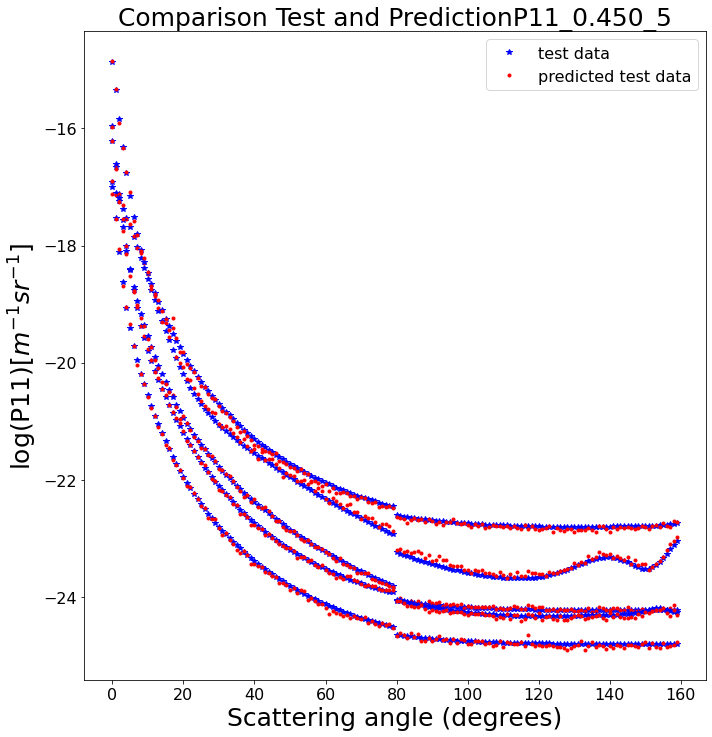

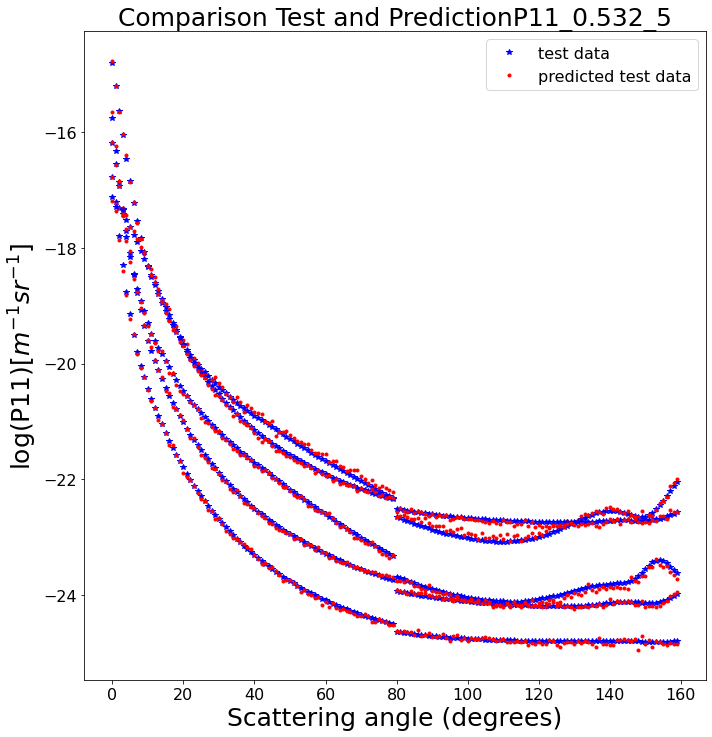

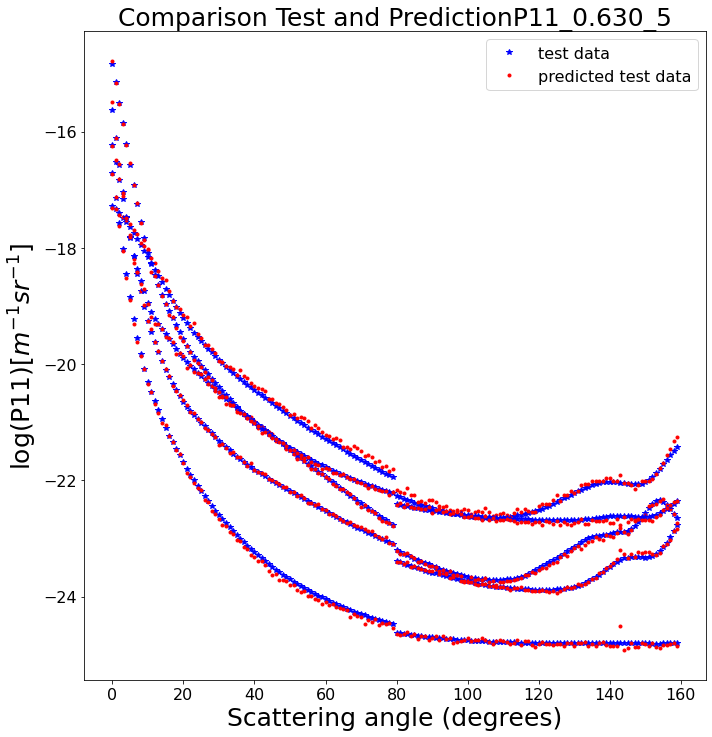

In [94]:
for wl_item in wl_list_P11:
    if len(wl_item) != 0:
        fig, ax = plt.subplots(figsize = (10,10))
        for index in presentation_plot_index:
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_test[wl_item].iloc[index],'b*')
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_pred_fw[wl_item].iloc[index],'r.')

        ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
        ax.set_ylabel('log(P11)[$m^{-1}sr^{-1}$]',fontsize = 25)
        ax.tick_params(labelsize = 16)    
        fig.tight_layout() 
        ax.set_title( 'Comparison Test and Prediction'+wl_item[0],fontsize = 25)
        ax.legend(['test data', 'predicted test data'], fontsize = 16)
        fig.savefig(f'{plot_dir}/phase_data__result_iv'+str(wl_item[0])+'.jpg')

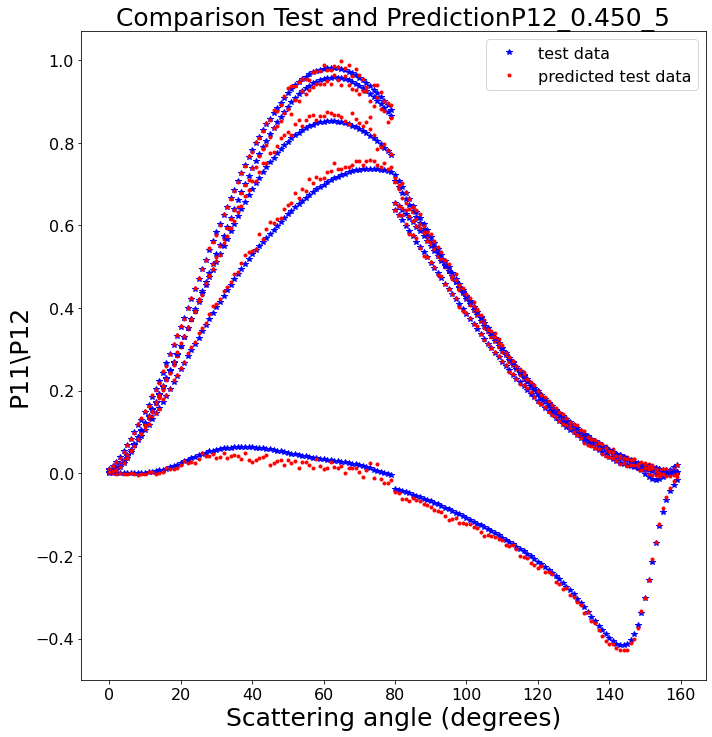

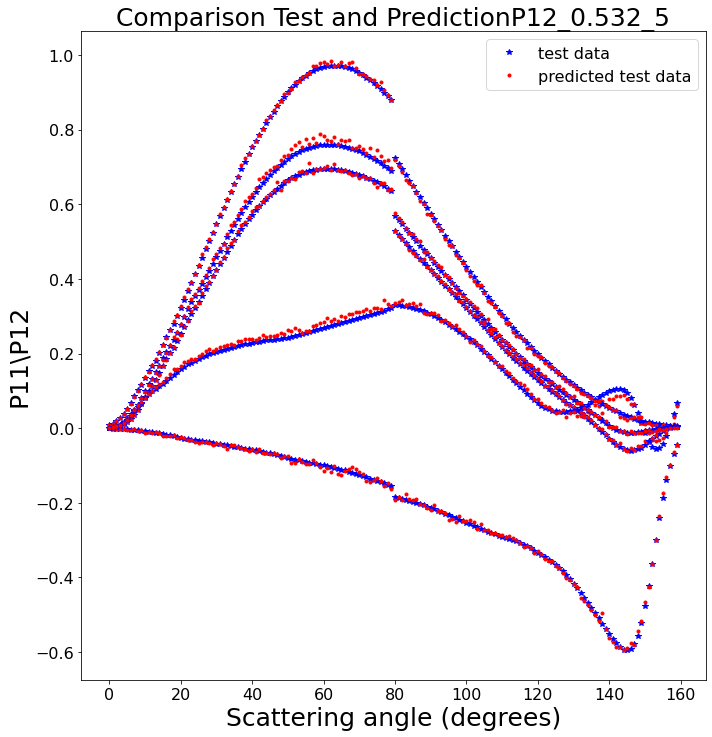

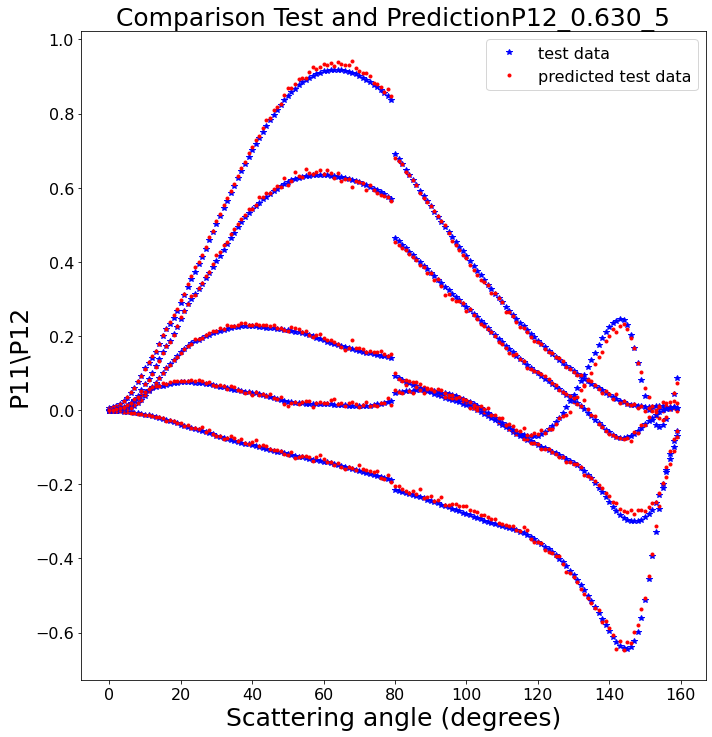

In [95]:
for wl_item in wl_list_P12:
    if len(wl_item) != 0:
        fig, ax = plt.subplots(figsize = (10,10))
        for index in presentation_plot_index:
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_test[wl_item].iloc[index],'b*')
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_pred_fw[wl_item].iloc[index],'r.')
    
    

        ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
        ax.set_ylabel('P11\P12',fontsize = 25)
        ax.tick_params(labelsize = 16)    
        fig.tight_layout() 
        ax.set_title( 'Comparison Test and Prediction'+wl_item[0],fontsize = 25)
        ax.legend(['test data', 'predicted test data'], fontsize = 16)
        fig.savefig(f'{plot_dir}/phase_data__result_iv'+str(wl_item[0])+'.jpg')

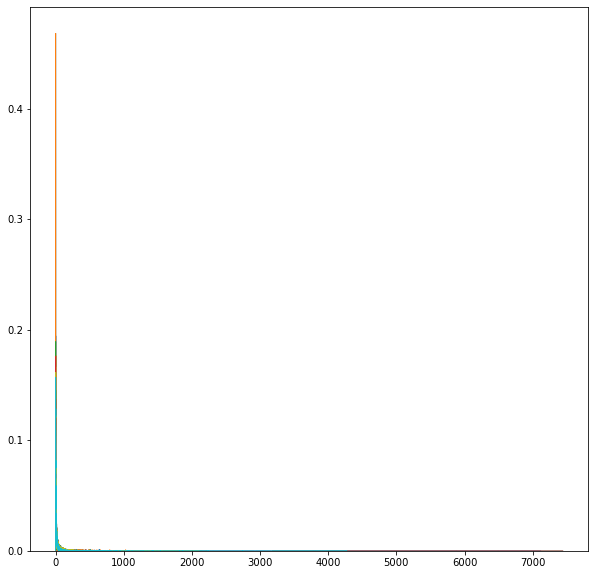

In [96]:
fig, ax = plt.subplots(figsize = (10,10))

x1data = []
x2data = []
y1data = []
y2data = []

for datapoint in presentation_plot_index:
    mu1 = dvar_pred_iv.iloc[datapoint]['R_median']
    sigma1 = dvar_pred_iv.iloc[datapoint]['GSD']
    mu2 = dvar_test.iloc[datapoint]['R_median']
    sigma2 = dvar_test.iloc[datapoint]['GSD']
    Vtot1 = dvar_pred_iv.iloc[datapoint]['V_tot']
    Vtot2 = dvar_test.iloc[datapoint]['V_tot']
    
    
    s1 = np.random.lognormal(mu1, sigma1, 100000)
    s2 = np.random.lognormal(mu2, sigma2, 100000)


    count1, bins1, ignored1 = plt.hist(s1, 100000, density=True, align='mid', histtype = 'step')
    count2, bins2, ignored2 = plt.hist(s2, 100000, density=True, align='mid', histtype = 'step')

    x1 = np.linspace(min(bins1), max(bins1), 1000000)
    x2 = np.linspace(min(bins2), max(bins2), 1000000)

    pdf1 = Vtot1*(np.exp(-(np.log(x1) - np.log(mu1))**2 / (2 * sigma1**2)) / (x1 * sigma1 * np.sqrt(2 * np.pi)))
    pdf2 = Vtot2*(np.exp(-(np.log(x2) - np.log(mu2))**2 / (2 * sigma2**2)) / (x2 * sigma2 * np.sqrt(2 * np.pi)))

    x1data.append(x1)
    x2data.append(x2)
    y1data.append(pdf1)
    y2data.append(pdf2)


100
2000
3000
5000


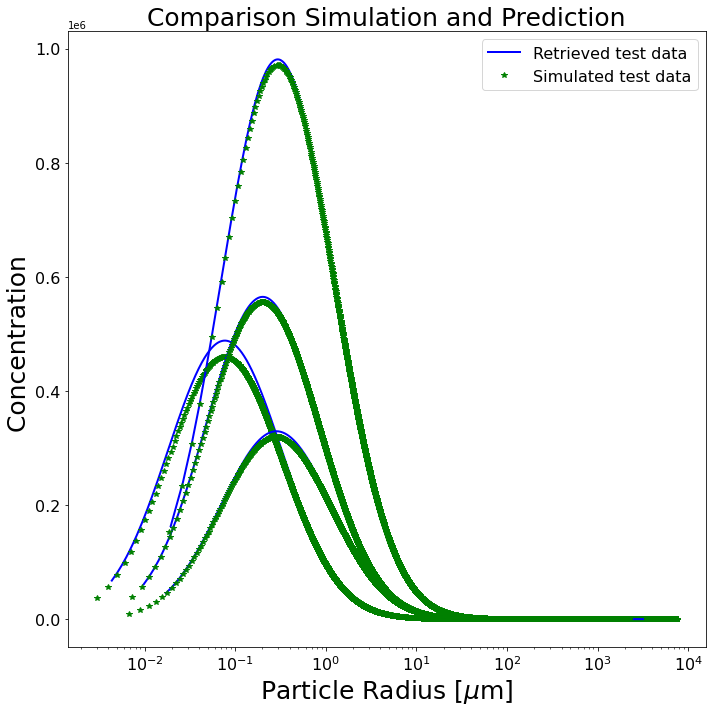

In [97]:
fig, ax = plt.subplots(figsize = (10,10))
for datalen in (0,1,2,3):
    print(presentation_plot_index[datalen])
     
    if datalen == 0:        
        ax.plot(x1data[datalen], y1data[datalen]*1000,'b', linewidth=2,label ='Retrieved test data')
        ax.plot(x2data[datalen], y2data[datalen]*1000, '*g',linewidth=1, label = 'Simulated test data')
    else:
        ax.plot(x1data[datalen], y1data[datalen]*1000,'b', linewidth=2)#,label ='Retrieved test data')
        ax.plot(x2data[datalen], y2data[datalen]*1000, '*g',linewidth=1)#, label = 'Simulated test data')
        
    
ax.legend(['Predicted test data', 'test data'], fontsize = 16)
ax.legend(fontsize = 16)   

ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/GSD_GMR_iv.jpg')

In [98]:
np.log(mu2)

0.5379037510502185

In [99]:
min(bins1)

0.011916817506968805

100
2000
3000
5000


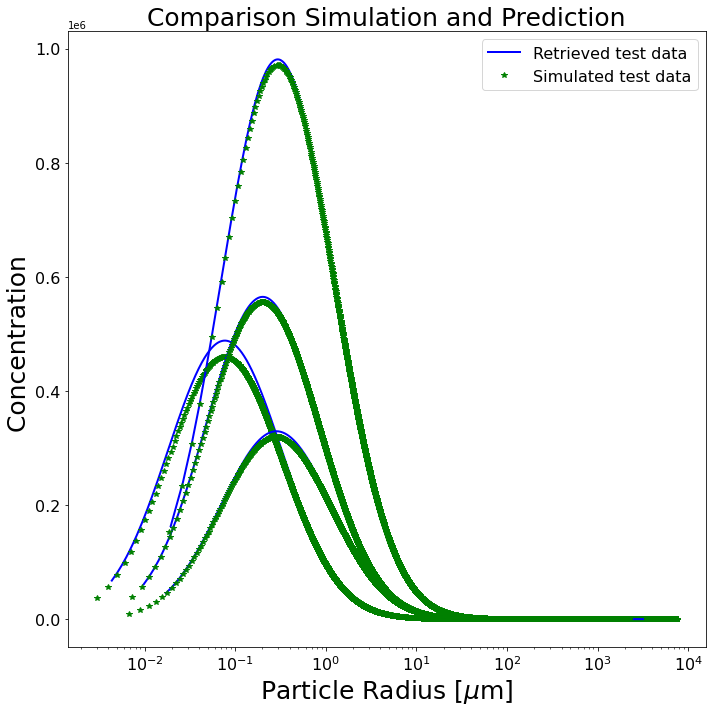

In [100]:
fig, ax = plt.subplots(figsize = (10,10))
for datalen in (0,1,2,3):
    print(presentation_plot_index[datalen])
     
    if datalen == 0:        
        ax.plot(x1data[datalen], y1data[datalen]*1000,'b', linewidth=2,label ='Retrieved test data')
        ax.plot(x2data[datalen], y2data[datalen]*1000, '*g',linewidth=1, label = 'Simulated test data')
    else:
        ax.plot(x1data[datalen], y1data[datalen]*1000,'b', linewidth=2)#,label ='Retrieved test data')
        ax.plot(x2data[datalen], y2data[datalen]*1000, '*g',linewidth=1)#, label = 'Simulated test data')
        
    
ax.legend(['Predicted test data', 'test data'], fontsize = 16)
ax.legend(fontsize = 16)   

ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/GSD_GMR_iv.jpg')

# plot correlation test data and predicted test data

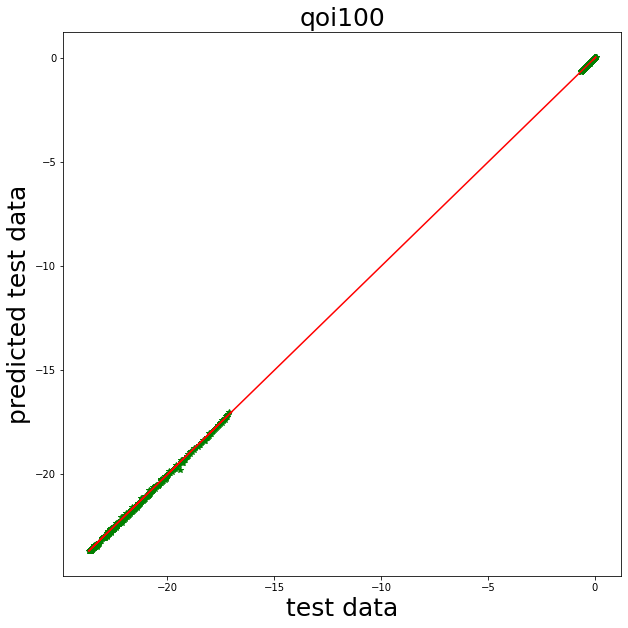

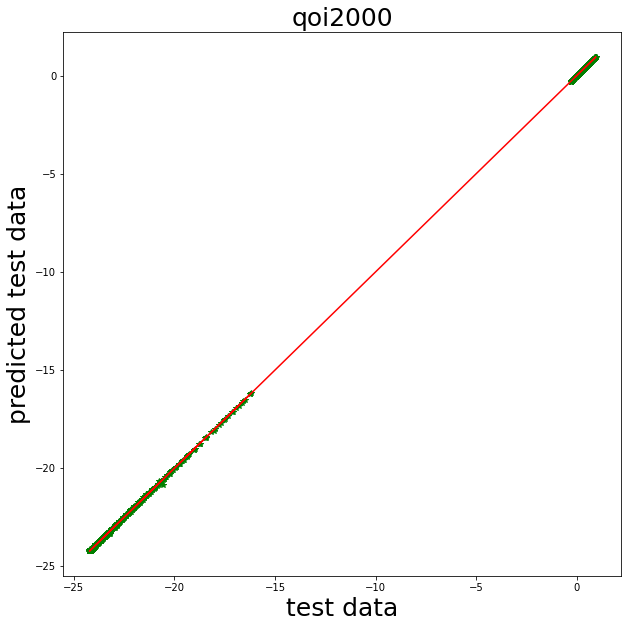

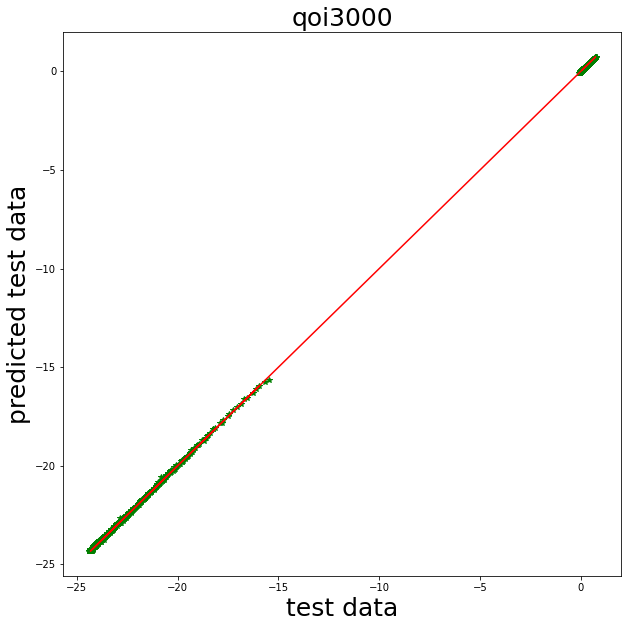

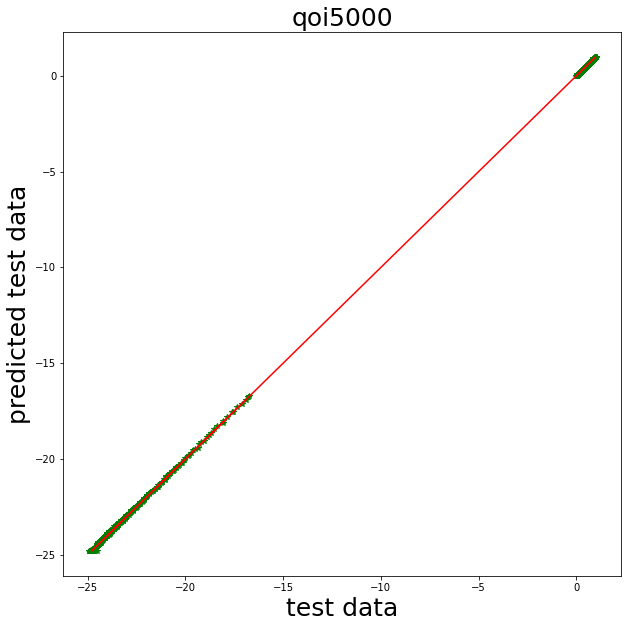

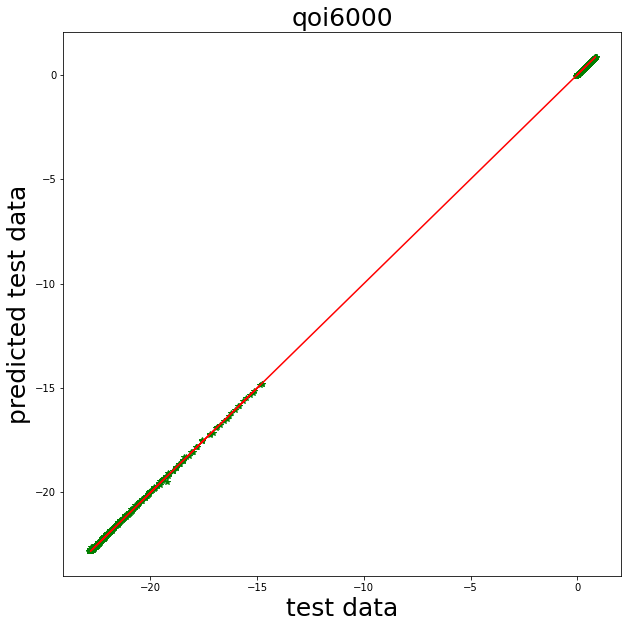

In [101]:
for index in presentation_plot_index:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(qoi_pred_fw.iloc[index],qoi_test.iloc[index],'g*')
    ax.plot(qoi_test.iloc[index],qoi_test.iloc[index],'r')
    ax.set_title('qoi'+str(index), fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

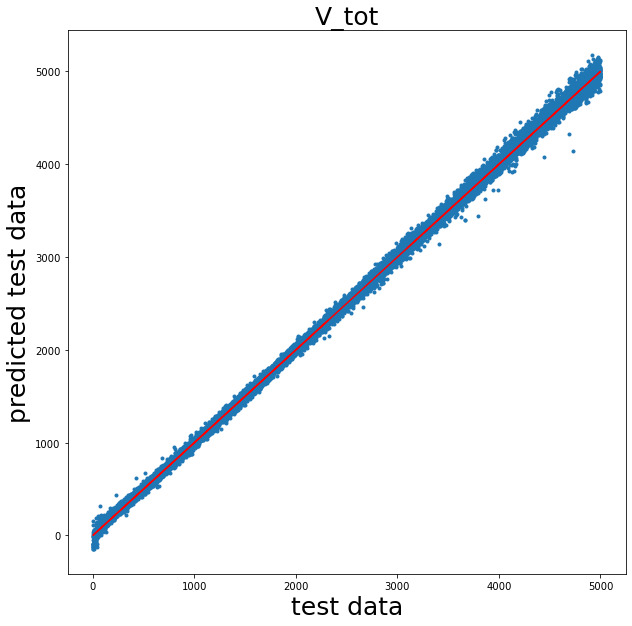

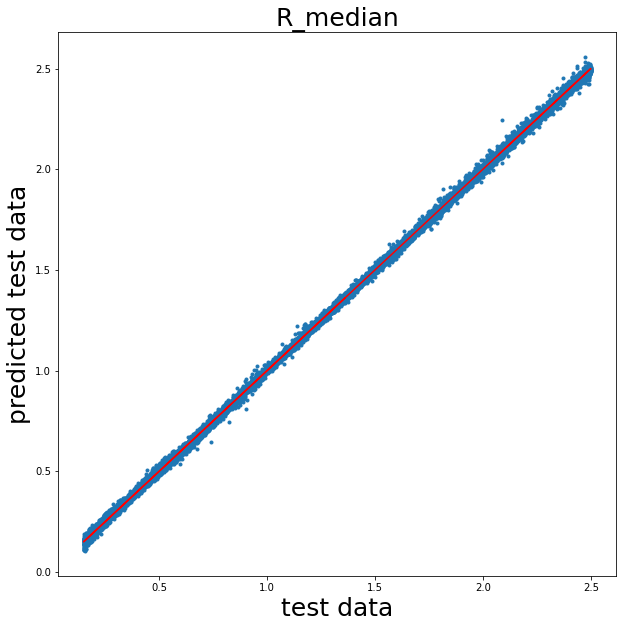

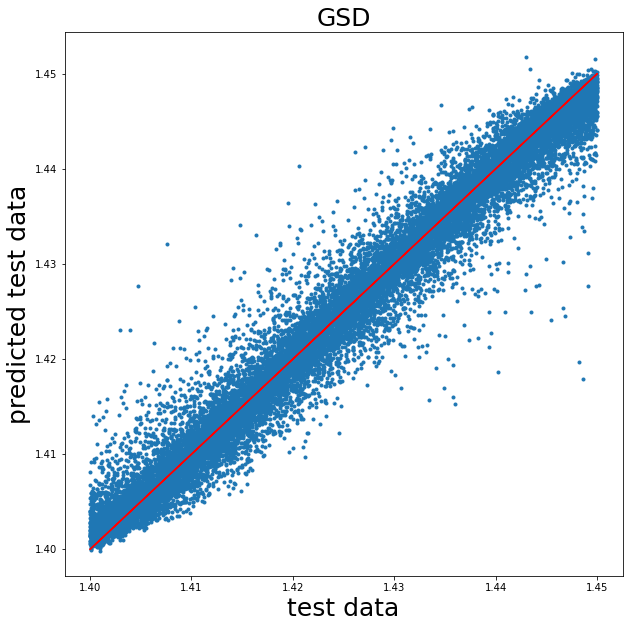

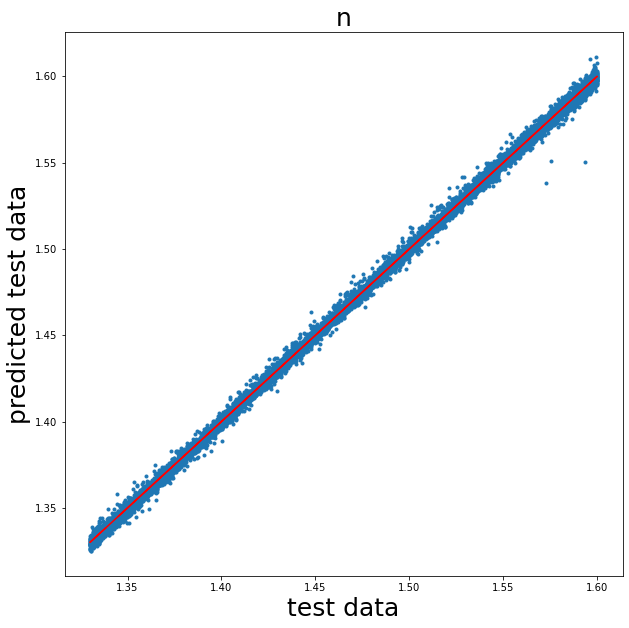

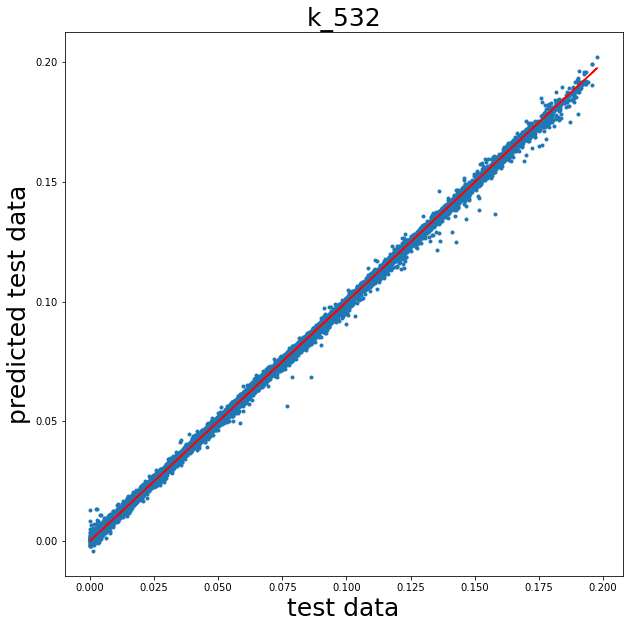

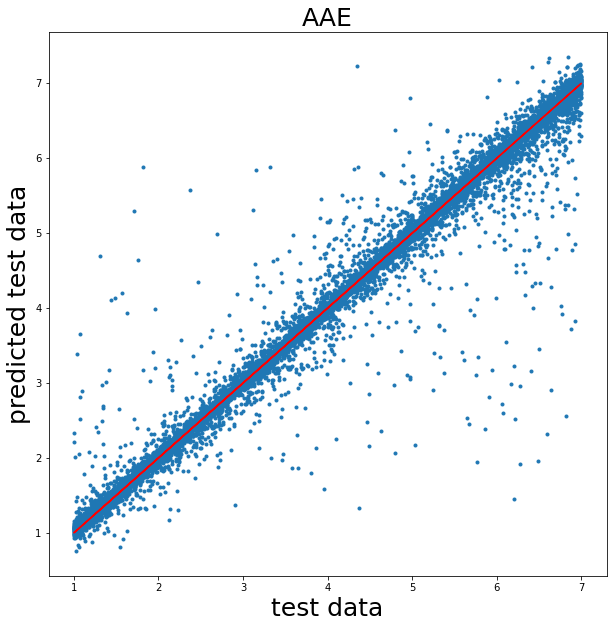

In [102]:
for key in dvar_columns:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(dvar_test[key],dvar_pred_iv[key],".")
    ax.plot(dvar_test[key],dvar_test[key],"r")
    ax.set_title(key, fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

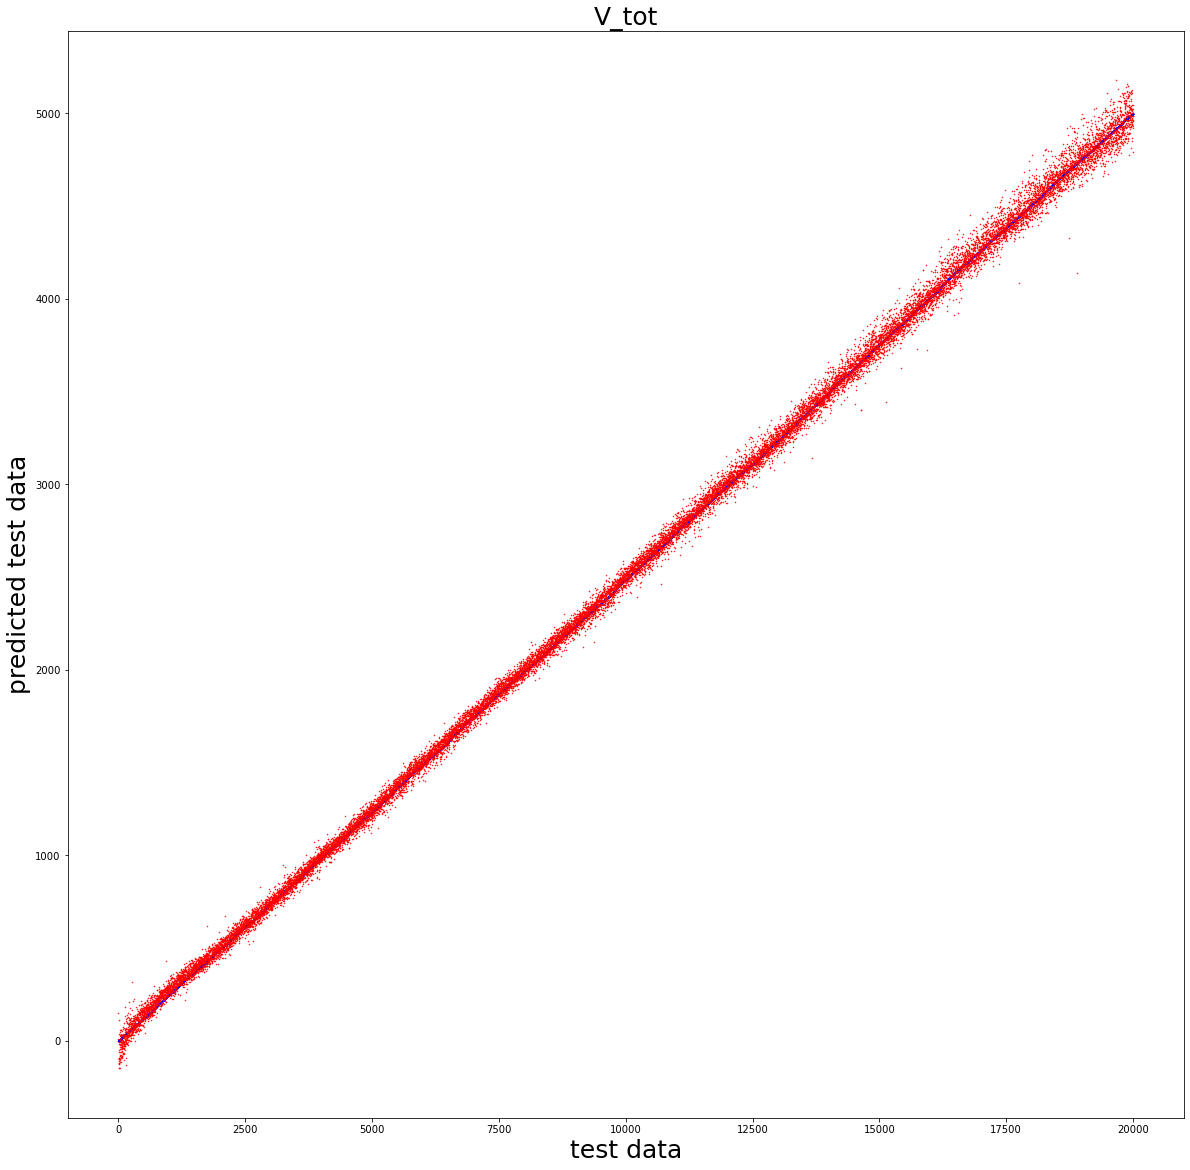

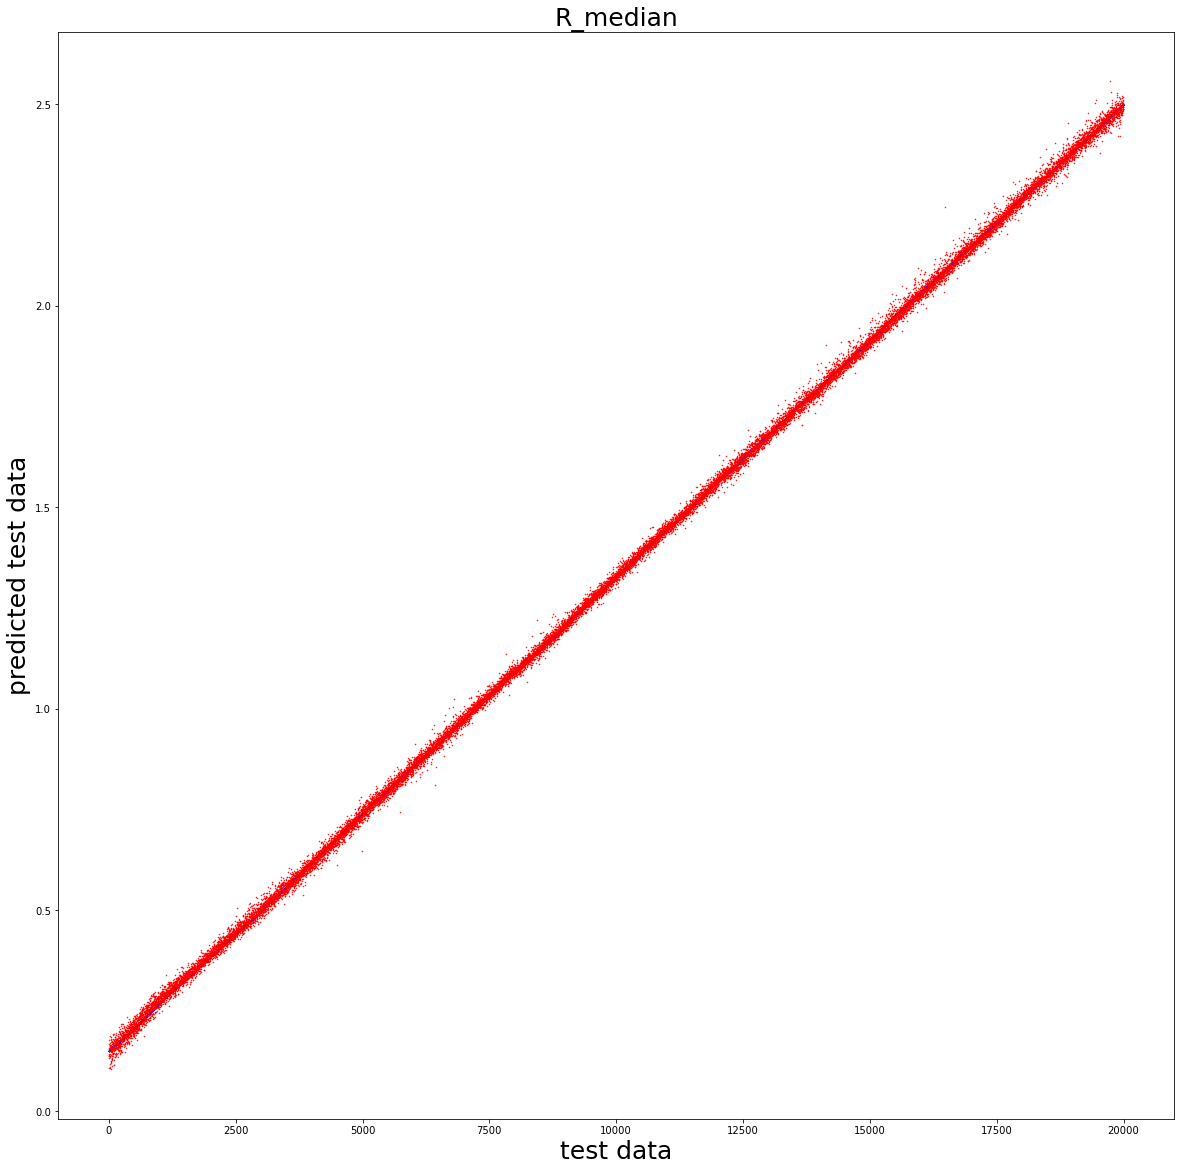

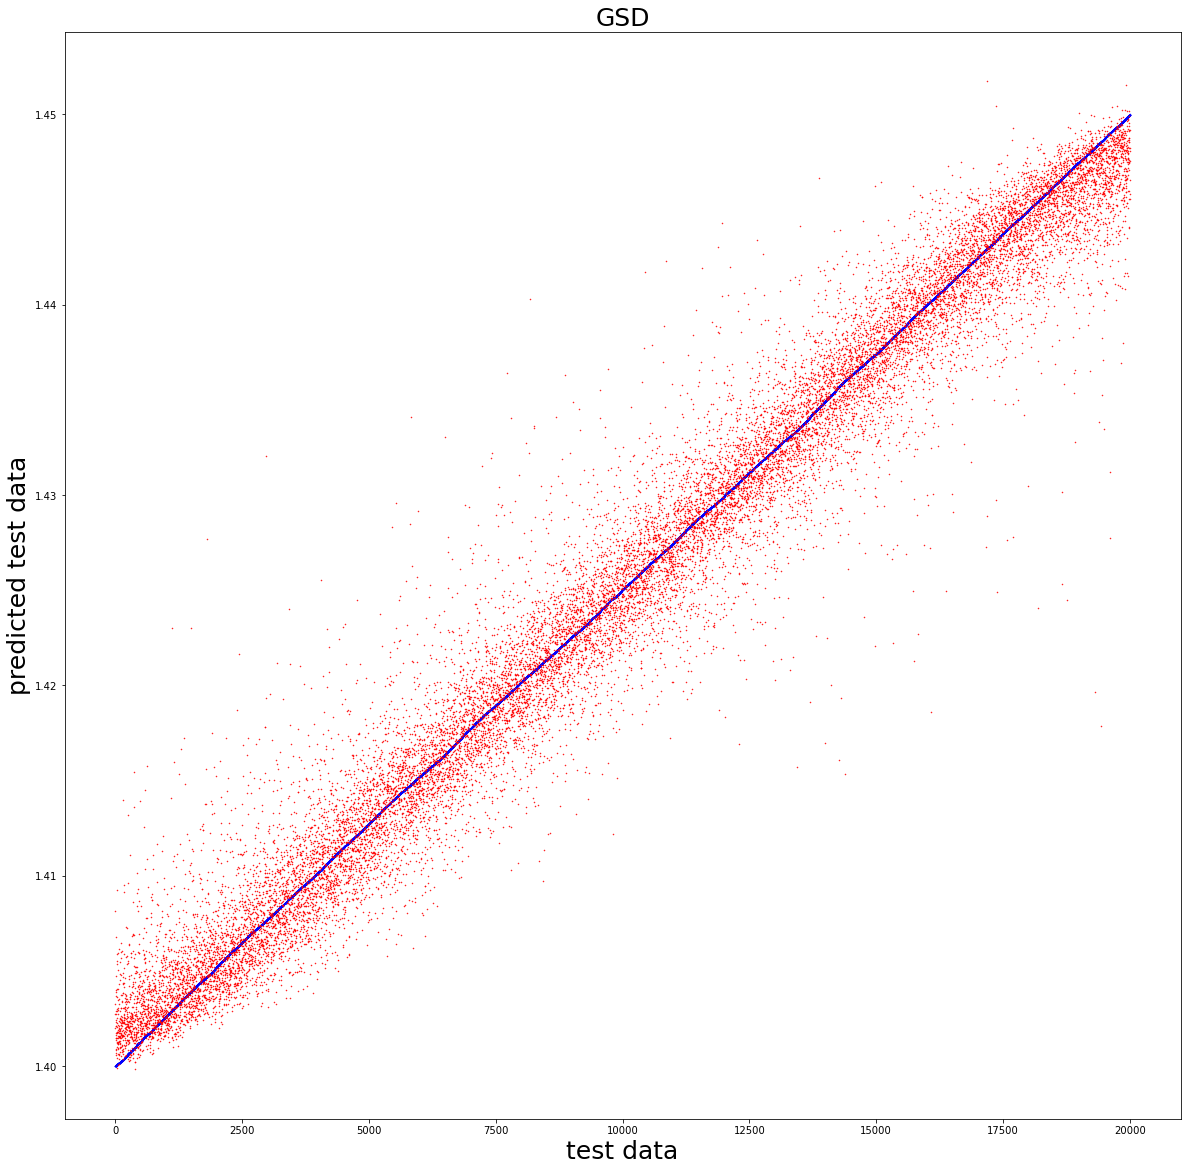

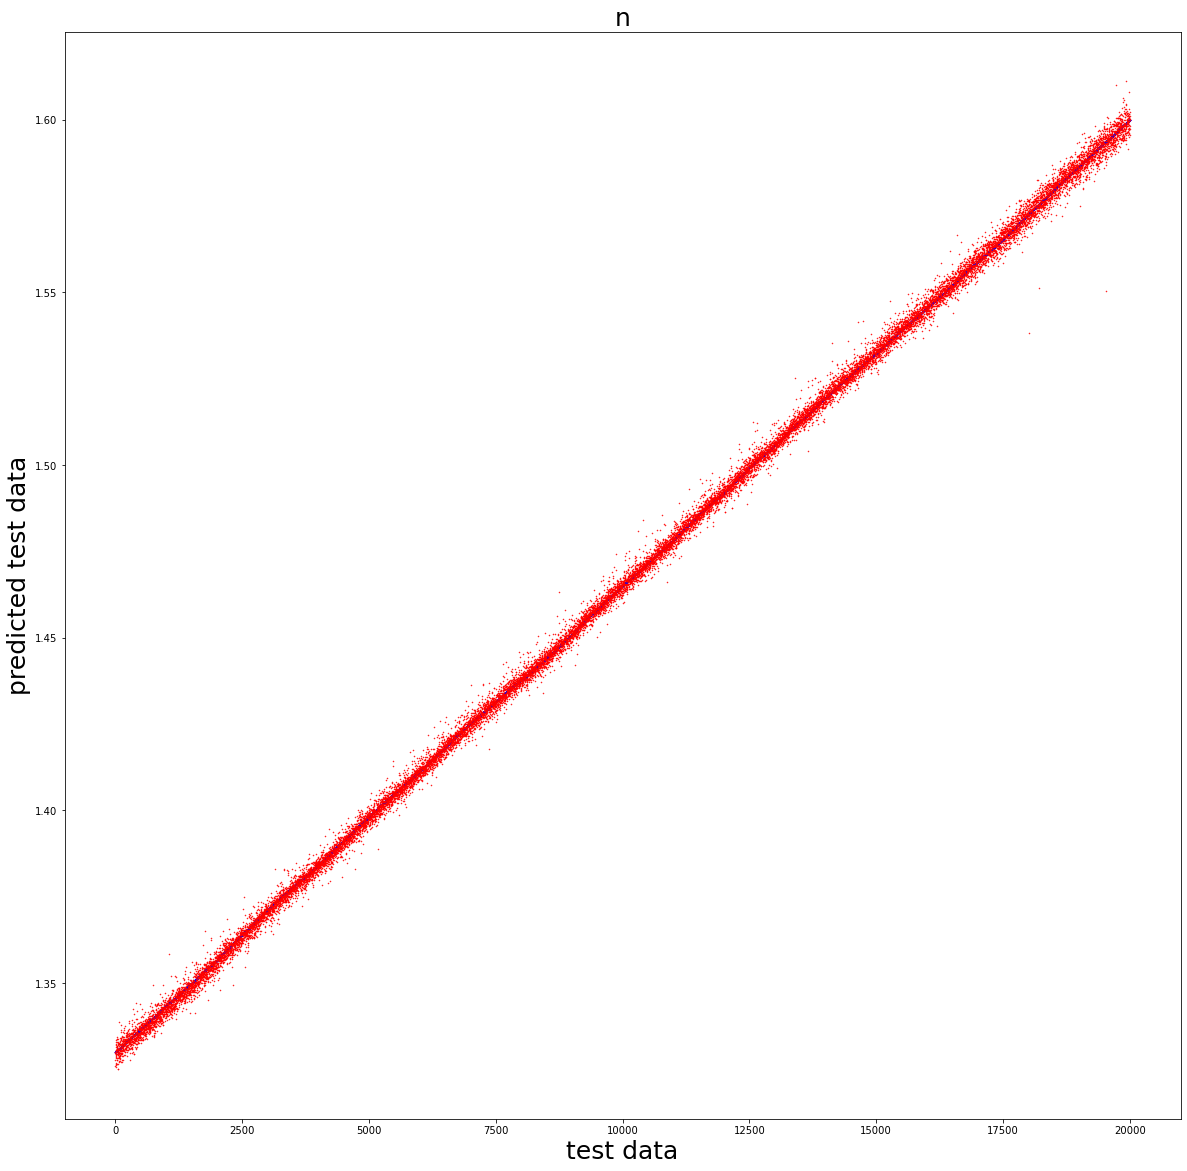

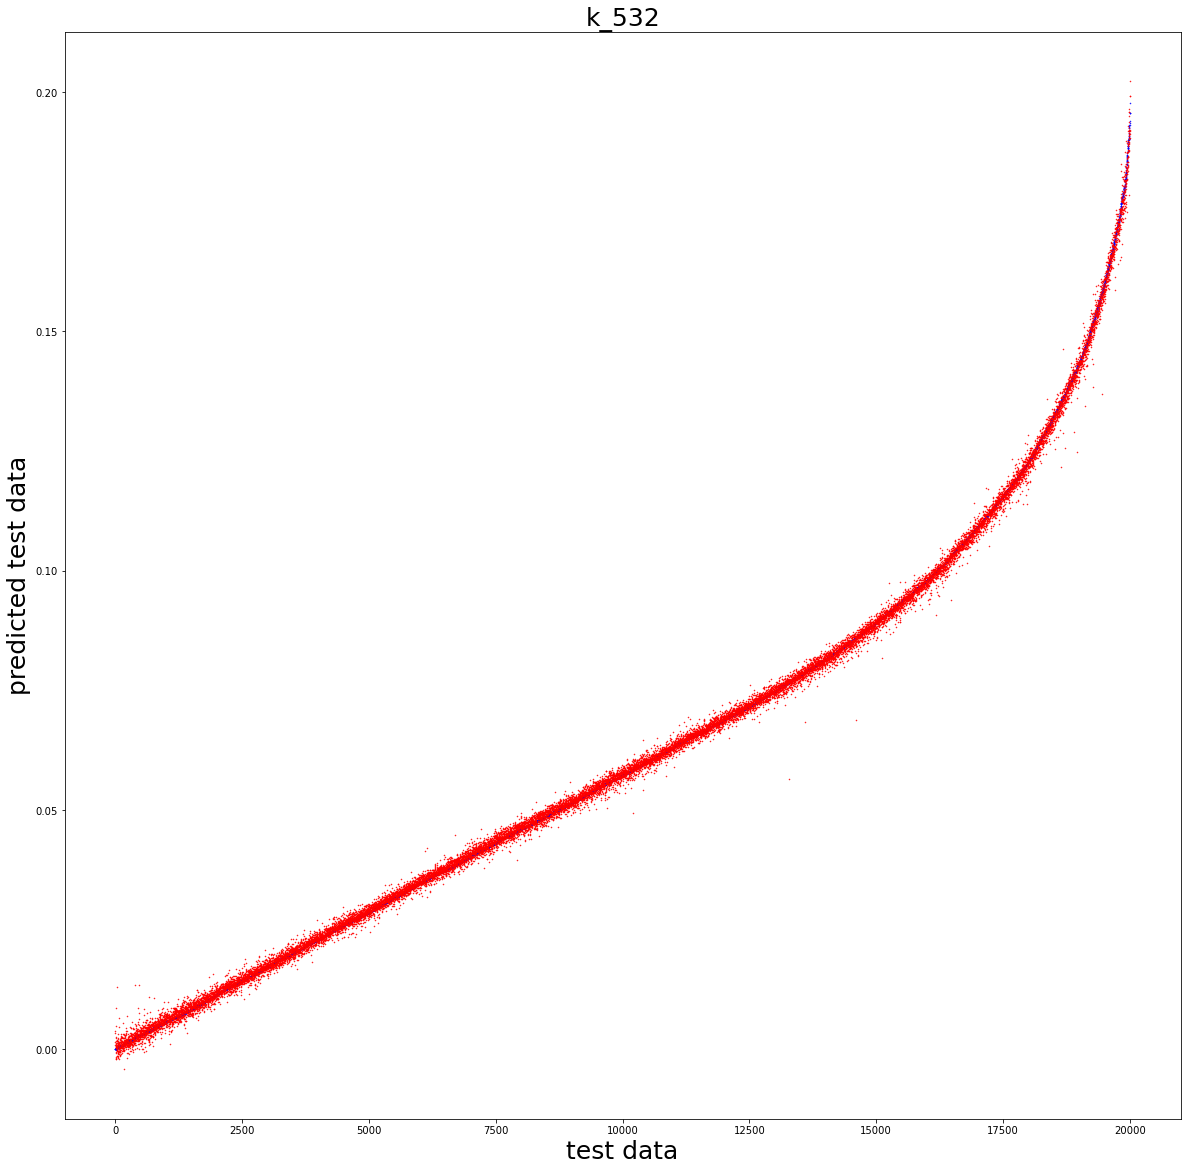

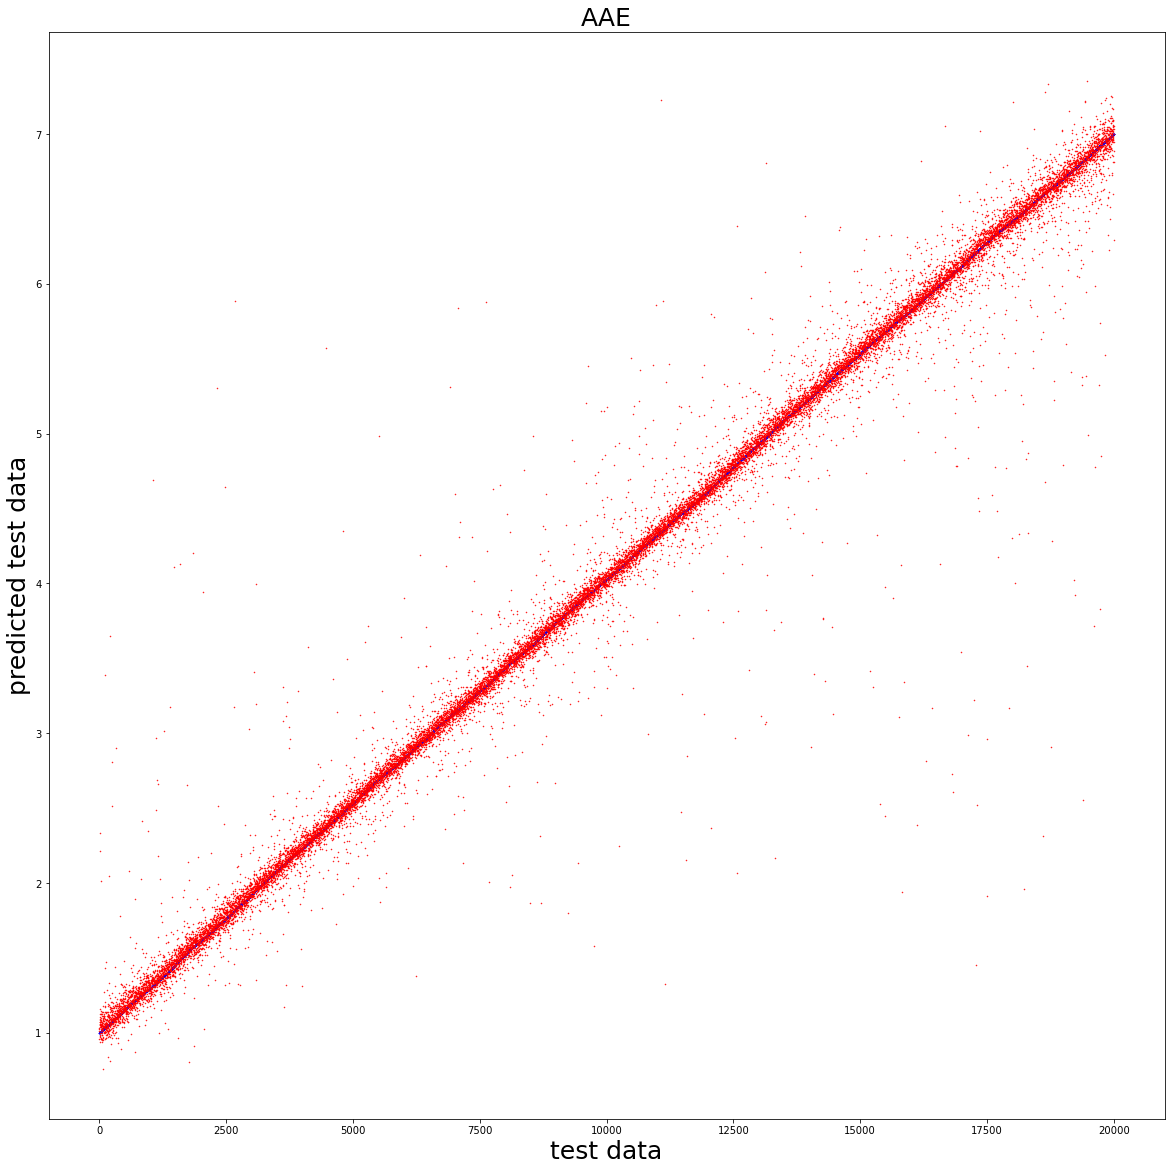

In [103]:
for key in dvar_test.columns:
    dvar_test_help = dvar_test.sort_values(key)
    dvar_pred_iv_df_help = dvar_pred_iv.loc[dvar_test_help.index]

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.plot(np.arange(0,len(dvar_test_help)),dvar_test_help[key],'b.', markersize = '1')
    ax.plot(np.arange(0,len(dvar_pred_iv_df_help)),dvar_pred_iv_df_help[key],'r.', markersize = '1')
    ax.set_title(key, fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

# plot r2 for forward and inverse model

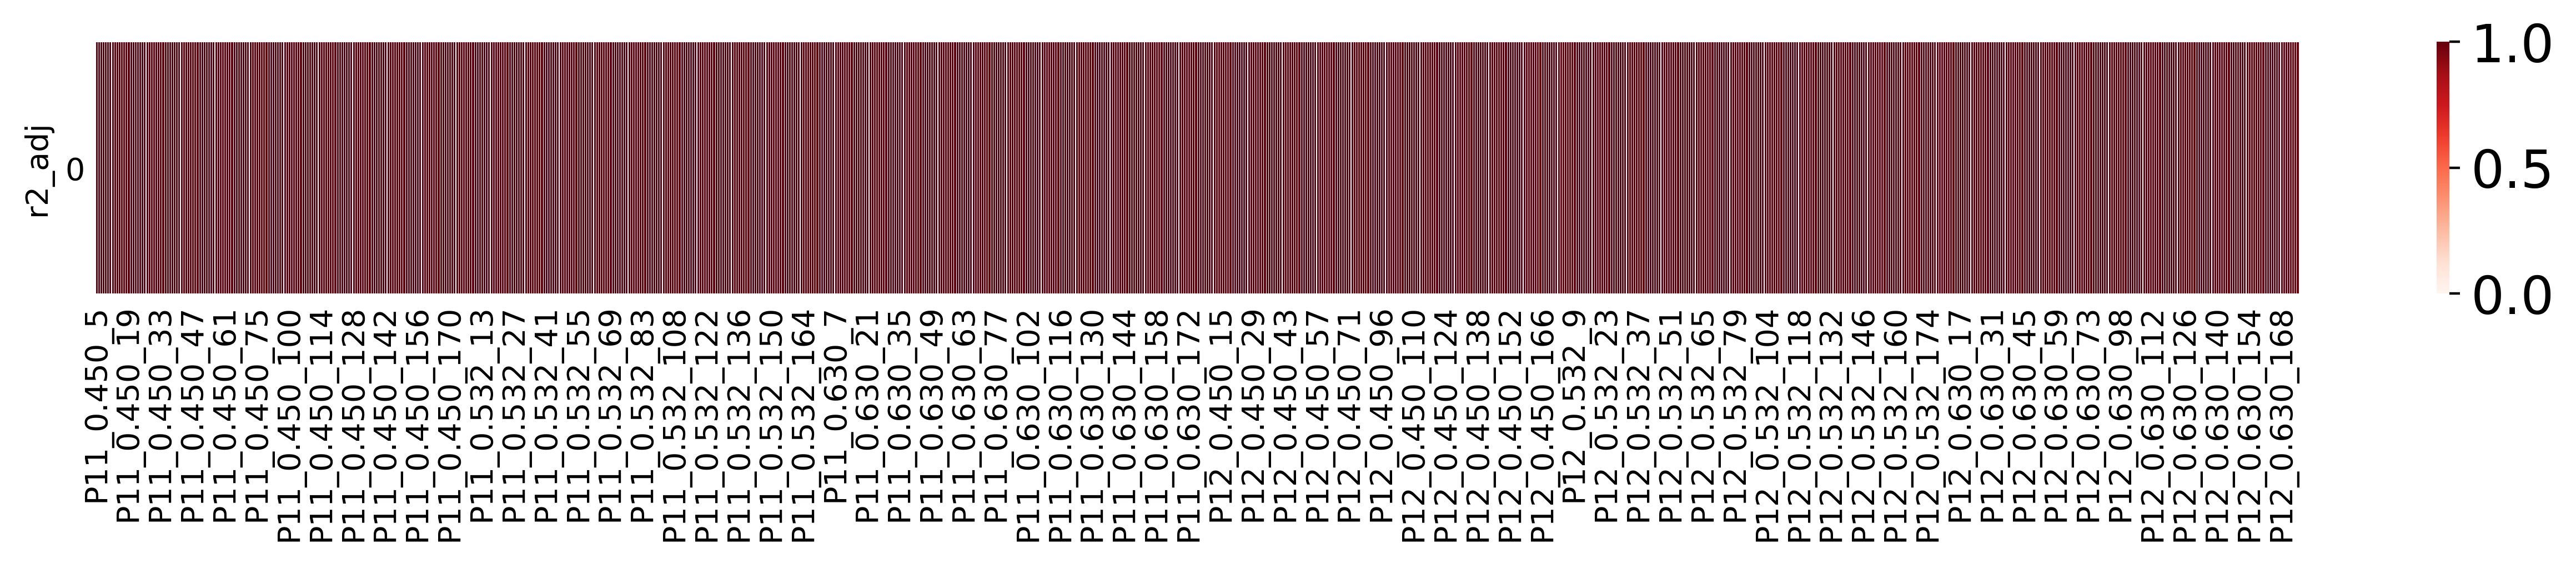

In [104]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(r2_adj_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
ax.set_ylabel('r2_adj')

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

fig.savefig(f'{plot_dir}/invertible_model_fw_r2_adj.jpg')


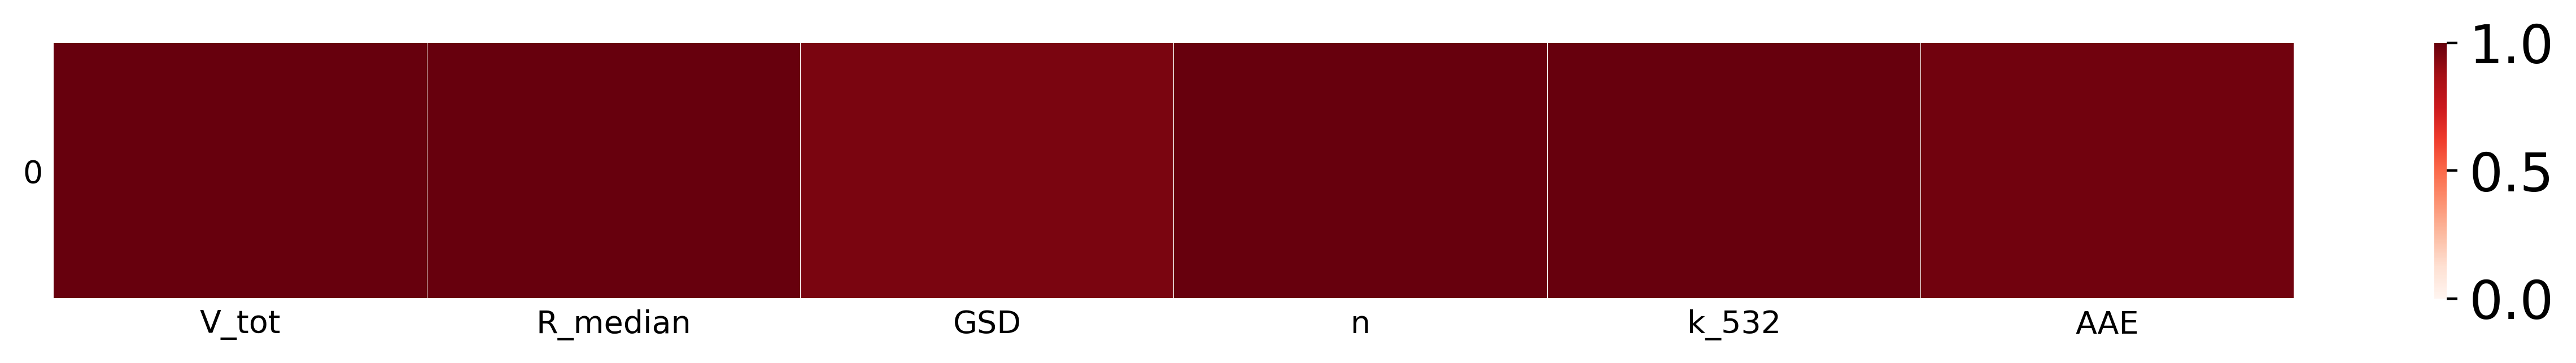

In [105]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(r2_adj_iv,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/invertible_model_inv_r2_adj.jpg')



# Plot Relative Errors / Absolute errors

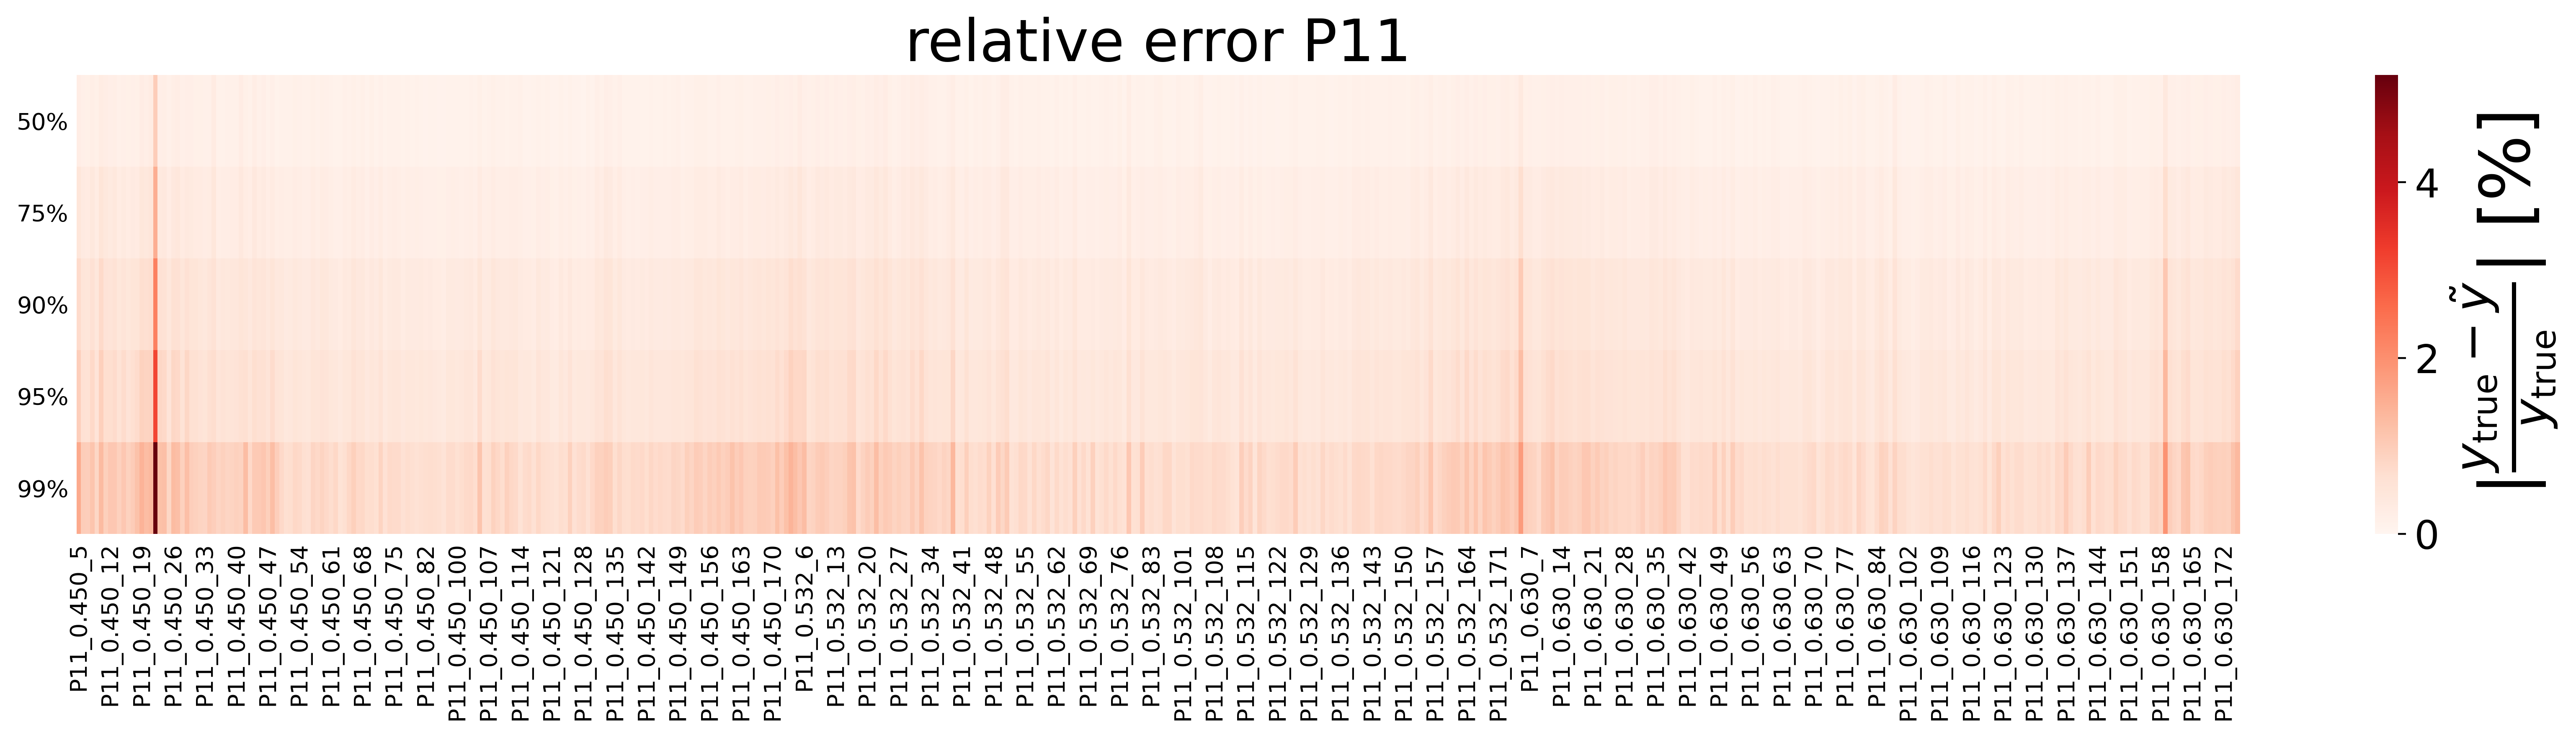

In [106]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_fw_P11,
            cmap='Reds',
           # annot=True,
           # linewidths=2.,
            vmin=0.,
            vmax=np.max(rel_error_table_fw_P11.max()),
           # annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)
ax.set_title('relative error P11', fontsize =25)
fig.tight_layout(rect=(0, 0, 1.05, 1))

fig.savefig(f'{plot_dir}/forward_rel_error_percentiles.jpg')

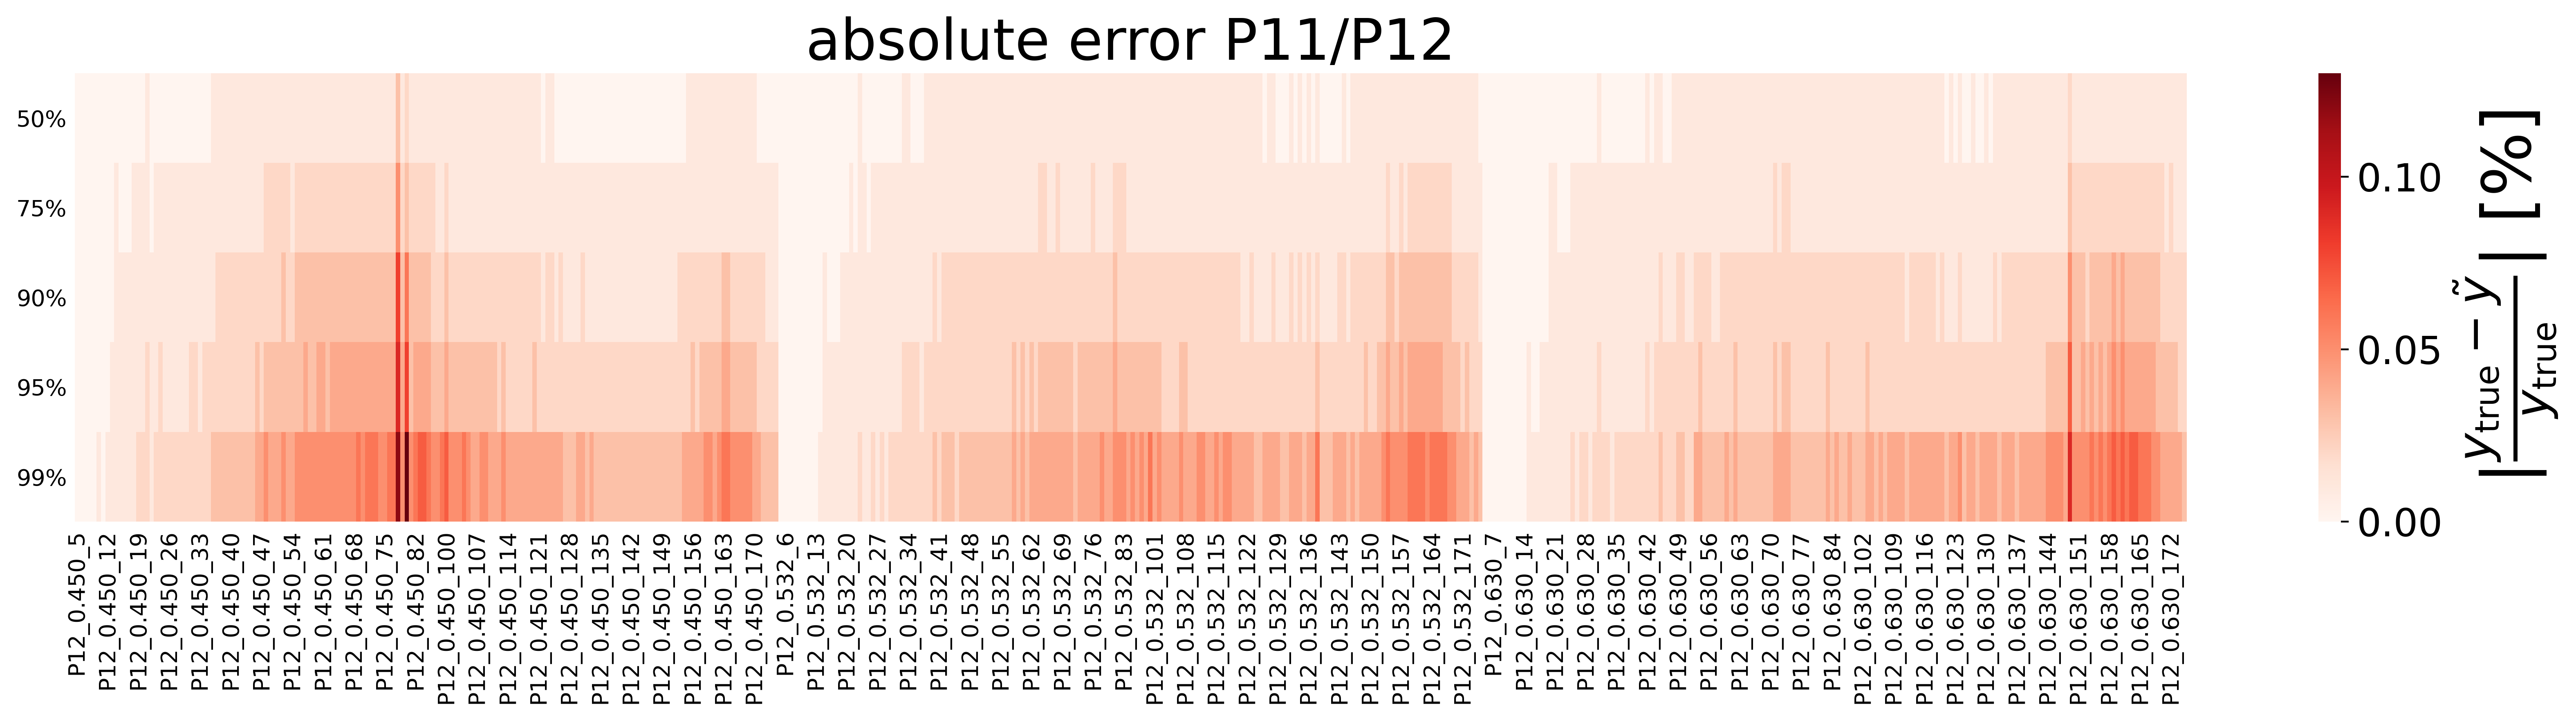

In [107]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(abs_error_table_fw_P12,
            cmap='Reds',
           # annot=True,
           # linewidths=2.,
            vmin=0.,
            vmax=np.max(abs_error_table_fw_P12.max()),
           # annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)
ax.set_title('absolute error P11/P12', fontsize =25)
fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/forward_rel_error_percentiles.jpg')

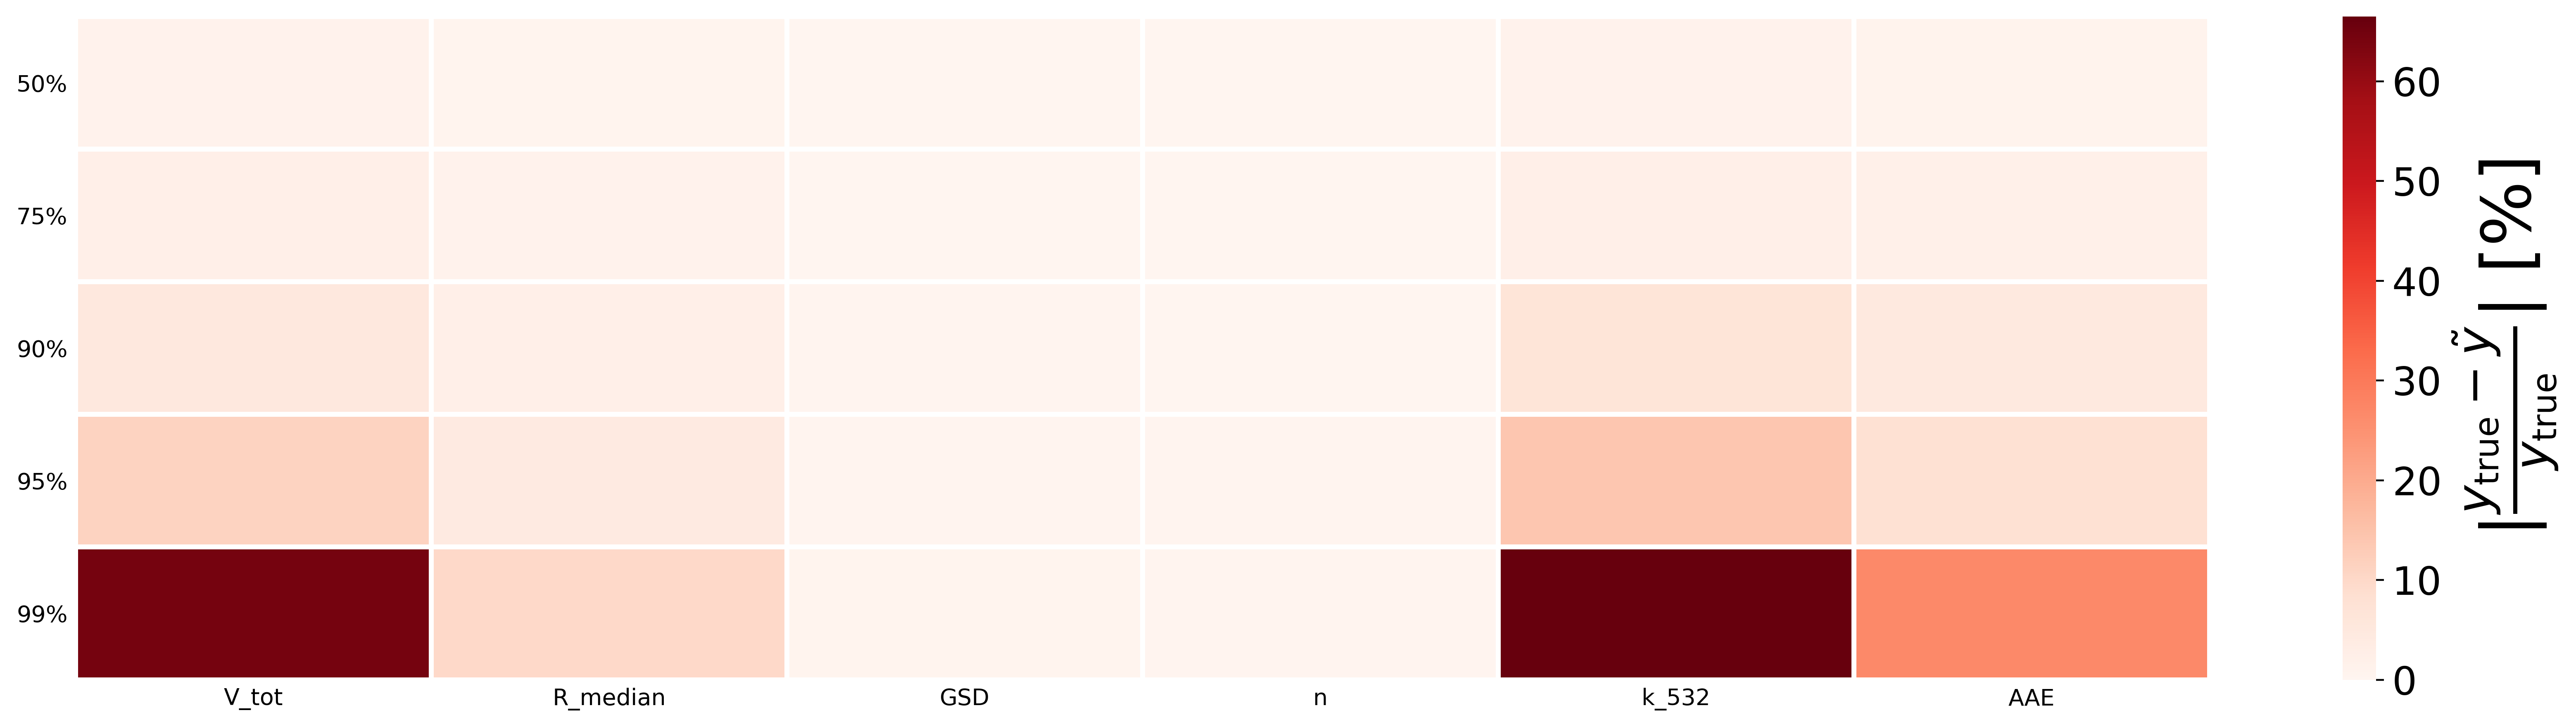

In [108]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_iv,
            cmap='Reds',
       #     annot=False,
            linewidths=2.,
            vmin=0.,
            vmax=np.max(rel_error_table_iv.max()),
      #      annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/invertible_sampling_rel_error_percentiles.jpg')


In [109]:
# Rework plots below

In [110]:
surr.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 962)]             0         
_________________________________________________________________
affine_coupling_block (Affin (None, 962)               390532    
_________________________________________________________________
permutation_layer (Permutati (None, 962)               0         
_________________________________________________________________
affine_coupling_block_1 (Aff (None, 962)               390532    
_________________________________________________________________
permutation_layer_1 (Permuta (None, 962)               0         
_________________________________________________________________
affine_coupling_block_2 (Aff (None, 962)               390532    
Total params: 1,171,596
Trainable params: 1,171,596
Non-trainable params: 0
___________________________________________________

In [111]:
from keras.utils.vis_utils import plot_model

In [112]:
plot_model(surr.model, show_shapes=False,show_layer_names=True,to_file = f'{plot_dir}/model_architecture_invertible.png')


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [113]:
r2_adj_fw = r2_adj_fw.rename({0: 'r2_adj'}, axis='index')
r2_adj_iv = r2_adj_iv.rename({0: 'r2_adj'}, axis='index')


# create overview plot

In [114]:
'''# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(r2_adj_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table_fw.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


#plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
#sns.heatmap(to_plot_fw,
#            vmin=-1.,
#            vmax=1.,
#            linewidths = 0.01,
#            cmap='coolwarm',)
#plt.tick_params(labelsize = 16)
#plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred_fw.columns)+3),qoi_pred_fw.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred_fw.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_invertible_model_fw.jpg')
'''


"# Plot figure with subplots of different sizes\nfig = plt.figure(1)\n# set up subplot grid\ngridspec.GridSpec(7,3)\n\nplt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)\nsns.heatmap(r2_adj_fw,\n            cmap='Reds',\n            linewidths=0.01,\n            vmin=0.,\n            vmax=1.,\n            xticklabels= False)\nplt.tick_params(labelsize = 16)    \nplt.title( 'Adjusted R2',fontsize = 25)\n\nplt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)\nsns.heatmap(rel_error_table_fw,\n            cmap='Reds',\n            linewidths=0.01,\n            vmin=0.,\n            vmax=np.max(rel_error_table_fw.max()),\n            xticklabels = False,\n            cbar_kws={'label': r'$\\left| \x0crac{y_\\mathrm{true} - \tilde{y}}{y_\\mathrm{true}} \right|$ [%]'})\nplt.tick_params(labelsize = 16)    \nplt.title( 'Relative Error',fontsize = 25)\n\n\n#plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)\n#sns.heatmap(to_plot_fw,\n#            vmin=-1.,\n#            vmax=1.,\n#     

In [115]:
'''# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(r2_adj_iv,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table_iv,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table_iv.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


#plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
#sns.heatmap(to_plot_iv,
#            vmin=-1.,
#            vmax=1.,
#            linewidths = 0.01,
#            cmap='coolwarm',)
#plt.tick_params(labelsize = 16)
#plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred_fw.columns)+3),qoi_pred_fw.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred_fw.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_invertible_model_iv.jpg')
'''


"# Plot figure with subplots of different sizes\nfig = plt.figure(1)\n# set up subplot grid\ngridspec.GridSpec(7,3)\n\nplt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)\nsns.heatmap(r2_adj_iv,\n            cmap='Reds',\n            linewidths=0.01,\n            vmin=0.,\n            vmax=1.,\n            xticklabels= False)\nplt.tick_params(labelsize = 16)    \nplt.title( 'Adjusted R2',fontsize = 25)\n\nplt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)\nsns.heatmap(rel_error_table_iv,\n            cmap='Reds',\n            linewidths=0.01,\n            vmin=0.,\n            vmax=np.max(rel_error_table_iv.max()),\n            xticklabels = False,\n            cbar_kws={'label': r'$\\left| \x0crac{y_\\mathrm{true} - \tilde{y}}{y_\\mathrm{true}} \right|$ [%]'})\nplt.tick_params(labelsize = 16)    \nplt.title( 'Relative Error',fontsize = 25)\n\n\n#plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)\n#sns.heatmap(to_plot_iv,\n#            vmin=-1.,\n#            vmax=1.,\n#     

In [116]:
configs = pd.read_csv(f'{model_dir}/configs.csv')
configs.columns

Index(['Unnamed: 0', 'MAE_train', 'MAE_val', 'MAPE_train', 'MAPE_val',
       'MSE_train', 'MSE_val', 'median_percentile_max_error_train',
       'median_percentile_max_error_val', '90_percentile_max_error_train',
       '90_percentile_max_error_val', 'r2_train', 'r2_val', 'r2_adj_train',
       'r2_adj_val', 'MAE_train_dvar', 'MAE_val_dvar', 'MAPE_train_dvar',
       'MAPE_val_dvar', 'MSE_train_dvar', 'MSE_val_dvar',
       'median_percentile_max_error_train_dvar',
       'median_percentile_max_error_val_dvar',
       '90_percentile_max_error_train_dvar',
       '90_percentile_max_error_val_dvar', 'r2_train_dvar', 'r2_val_dvar',
       'r2_adj_train_dvar', 'r2_adj_val_dvar', 'time_this_iter_s', 'done',
       'timesteps_total', 'episodes_total', 'training_iteration',
       'experiment_id', 'date', 'timestamp', 'time_total_s', 'pid', 'hostname',
       'node_ip', 'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'trial_id',
       'config/activation_f

In [117]:
store_results = pd.DataFrame()


In [118]:
store_results['data_file'] = configs['config/datafile']
store_results['batch_size'] = configs['config/batch_size']
store_results['learning_rate'] = configs['config/learning_rate']
store_results['n_blocks'] = configs['config/n_blocks']
store_results['n_depth'] = configs['config/n_depth']
store_results['n_width'] = configs['config/n_width']
store_results['weight_x'] = configs['config/weight_x']
store_results['weight_y'] = configs['config/weight_y']
store_results['weight_z'] = configs['config/weight_z']
store_results['weight_artificial'] = configs['config/weight_artificial']
store_results['weight_reconstruction'] = configs['config/weight_reconstruction']
store_results['r2_train_qoi_mean'] = configs['r2_train']
store_results['r2_val_qoi_mean'] = configs['r2_val']
store_results['r2_test_qoi_mean'] = r2_adj_fw.mean(axis =1).values
if 'P11' in qoi_columns[0]:
    store_results['rel_error95%_qoi_P11_max'] = rel_error_table_fw_P11.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P11_max'] = abs_error_table_fw_P11.max(axis = 1)['95%']
else:
    store_results['rel_error95%_qoi_P11_max'] = 0
    store_results['abs_error95%_qoi_P11_max'] = 0
if 'P12' in qoi_columns[-1]:
    store_results['rel_error95%_qoi_P12_max'] = rel_error_table_fw_P12.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P12_max'] = abs_error_table_fw_P12.max(axis = 1)['95%']
else:    
    store_results['rel_error95%_qoi_P12_max'] = 0
    store_results['rel_error95%_qoi_P12_max'] = 0
store_results['MAE_qoi_max'] = MAE_all_qoi.max(axis= 1).values
store_results['MAPE%_qoi_max'] = MAPE_all_qoi.max(axis= 1).values
store_results['explained_variance_qoi_min'] = EVS_all_df.min(axis = 1)

store_results['r2_train_dvar_mean'] = configs['r2_train_dvar']
store_results['r2_val_dvar_mean'] = configs['r2_val_dvar']
store_results['r2_test_dvar_mean'] = r2_adj_iv.mean(axis = 1).values



store_results['r2_test_dvar_V'] = r2_adj_iv['V_tot']['r2_adj']
store_results['rel_error95%_dvar_V'] = rel_error_table_iv['V_tot']['95%']
store_results['abs_error95%_dvar_V'] = abs_error_table_iv['V_tot']['95%']
store_results['MAE_dvar_V'] = MAE_all_dvar['V_tot'].values
store_results['MAPE%_dvar_V'] = MAPE_all_dvar['V_tot'].values
store_results['explained_variance_dvar_V'] = EVS_dvar['V_tot']

store_results['r2_test_dvar_R'] = r2_adj_iv['R_median']['r2_adj']
store_results['rel_error95%_dvar_R'] = rel_error_table_iv['R_median']['95%']
store_results['abs_error95%_dvar_R'] = abs_error_table_iv['R_median']['95%']
store_results['MAE_dvar_R'] = MAE_all_dvar['R_median'].values
store_results['MAPE%_dvar_R'] = MAPE_all_dvar['R_median'].values
store_results['explained_variance_dvar_R'] = EVS_dvar['R_median']

store_results['r2_test_dvar_GSD'] = r2_adj_iv['GSD']['r2_adj']
store_results['rel_error95%_dvar_GSD'] = rel_error_table_iv['GSD']['95%']
store_results['abs_error95%_dvar_GSD'] = abs_error_table_iv['GSD']['95%']
store_results['MAE_dvar_GSD'] = MAE_all_dvar['GSD'].values
store_results['MAPE%_dvar_GSD'] = MAPE_all_dvar['GSD'].values
store_results['explained_variance_dvar_GSD'] = EVS_dvar['GSD']

if 'n' in dvar_columns:  
    store_results['r2_test_dvar_n'] = r2_adj_iv['n']['r2_adj']
    store_results['rel_error95%_dvar_n'] = rel_error_table_iv['n']['95%']
    store_results['abs_error95%_dvar_n'] = abs_error_table_iv['n']['95%']
    store_results['MAE_dvar_n'] = MAE_all_dvar['n'].values
    store_results['MAPE%_dvar_n'] = MAPE_all_dvar['n'].values
    store_results['explained_variance_dvar_n'] = EVS_dvar['n']
else:
    store_results['r2_test_dvar_n'] = 0
    store_results['rel_error95%_dvar_n'] = 0
    store_results['abs_error95%_dvar_n'] = 0
    store_results['MAE_dvar_n'] = 0
    store_results['MAPE%_dvar_n'] = 0
    store_results['explained_variance_dvar_n'] = 0   



if 'n_532nm' in dvar_columns:    
    store_results['r2_test_dvar_n_532'] = r2_adj_iv['n_532nm']['r2_adj']
    store_results['rel_error95%_dvar_n_532'] = rel_error_table_iv['n_532nm']['95%']
    store_results['abs_error95%_dvar_n_532'] = abs_error_table_iv['n_532nm']['95%']
    store_results['MAE_dvar_n_532'] = MAE_all_dvar['n_532nm'].values
    store_results['MAPE%_dvar_n_532'] = MAPE_all_dvar['n_532nm'].values
    store_results['explained_variance_dvar_n_532'] = EVS_dvar['n_532nm']

else:
    store_results['r2_test_dvar_n_532'] = 0
    store_results['rel_error95%_dvar_n_532'] = 0
    store_results['abs_error95%_dvar_n_532'] = 0
    store_results['MAE_dvar_n_532'] = 0
    store_results['MAPE%_dvar_n_532'] = 0
    store_results['explained_variance_dvar_n_532'] = 0


if 'k_532nm' in dvar_columns:    
    store_results['r2_test_dvar_k_532'] = r2_adj_iv['k_532nm']['r2_adj']
    store_results['rel_error95%_dvar_k_532'] = rel_error_table_iv['k_532nm']['95%']
    store_results['abs_error95%_dvar_k_532'] = abs_error_table_iv['k_532nm']['95%']
    store_results['MAE_dvar_k_532'] = MAE_all_dvar['k_532nm'].values
    store_results['MAPE%_dvar_k_532'] = MAPE_all_dvar['k_532nm'].values
    store_results['explained_variance_dvar_k_532'] = EVS_dvar['k_532nm']

else:
    store_results['r2_test_dvar_k_532'] = 0
    store_results['rel_error95%_dvar_k_532'] = 0
    store_results['abs_error95%_dvar_k_532'] = 0
    store_results['MAE_dvar_k_532'] = 0
    store_results['MAPE%_dvar_k_532'] = 0
    store_results['explained_variance_dvar_k_532'] = 0
    
if 'n_450nm' in dvar_columns:  
    store_results['r2_test_dvar_n_450'] = r2_adj_iv['n_450nm']['r2_adj']
    store_results['rel_error95%_dvar_n_450'] = rel_error_table_iv['n_450nm']['95%']
    store_results['abs_error95%_dvar_n_450'] = abs_error_table_iv['n_450nm']['95%']
    store_results['MAE_dvar_n_450'] = MAE_all_dvar['n_450nm'].values
    store_results['MAPE%_dvar_n_450'] = MAPE_all_dvar['n_450nm'].values
    store_results['explained_variance_dvar_n_450'] = EVS_dvar['n_450nm']
    
else:
    store_results['r2_test_dvar_n_450'] = 0
    store_results['rel_error95%_dvar_n_450'] = 0
    store_results['abs_error95%_dvar_n_450'] = 0
    store_results['MAE_dvar_n_450'] = 0
    store_results['MAPE%_dvar_n_450'] = 0
    store_results['explained_variance_dvar_n_450'] = 0
    
if 'k_450nm' in dvar_columns:  
    store_results['r2_test_dvar_k_450'] = r2_adj_iv['k_450nm']['r2_adj']
    store_results['rel_error95%_dvar_k_450'] = rel_error_table_iv['k_450nm']['95%']
    store_results['abs_error95%_dvar_k_450'] = abs_error_table_iv['k_450nm']['95%']
    store_results['MAE_dvar_k_450'] = MAE_all_dvar['k_450nm'].values
    store_results['MAPE%_dvar_k_450'] = MAPE_all_dvar['k_450nm'].values
    store_results['explained_variance_dvar_k_450'] = EVS_dvar['k_450nm']
    
else:
    store_results['r2_test_dvar_k_450'] = 0
    store_results['rel_error95%_dvar_k_450'] = 0
    store_results['abs_error95%_dvar_k_450'] = 0
    store_results['MAE_dvar_k_450'] = 0
    store_results['MAPE%_dvar_k_450'] = 0
    store_results['explained_variance_dvar_k_450'] = 0
    
if 'n_630nm' in dvar_columns:    
    store_results['r2_test_dvar_n_630'] = r2_adj_iv['n_630nm']['r2_adj']
    store_results['rel_error95%_dvar_n_630'] = rel_error_table_iv['n_630nm']['95%']
    store_results['abs_error95%_dvar_n_630'] = abs_error_table_iv['n_630nm']['95%']
    store_results['MAE_dvar_n_630'] = MAE_all_dvar['n_630nm'].values
    store_results['MAPE%_dvar_n_630'] = MAPE_all_dvar['n_630nm'].values
    store_results['explained_variance_dvar_n_630'] = EVS_dvar['n_630nm']
else:
    store_results['r2_test_dvar_n_630'] = 0
    store_results['rel_error95%_dvar_n_630'] = 0
    store_results['abs_error95%_dvar_n_630'] = 0
    store_results['MAE_dvar_n_630'] =0
    store_results['MAPE%_dvar_n_630'] =0
    store_results['explained_variance_dvar_n_630'] = 0
      
    
if 'k_630nm' in dvar_columns:    
    store_results['r2_test_dvar_k_630'] = r2_adj_iv['k_630nm']['r2_adj']
    store_results['rel_error95%_dvar_k_630'] = rel_error_table_iv['k_630nm']['95%']
    store_results['abs_error95%_dvar_k_630'] = abs_error_table_iv['k_630nm']['95%']
    store_results['MAE_dvar_k_630'] = MAE_all_dvar['k_630nm'].values
    store_results['MAPE%_dvar_k_630'] = MAPE_all_dvar['k_630nm'].values
    store_results['explained_variance_dvar_k_630'] = EVS_dvar['k_630nm']
else:
    store_results['r2_test_dvar_k_630'] = 0
    store_results['rel_error95%_dvar_k_630'] = 0
    store_results['abs_error95%_dvar_k_630'] = 0
    store_results['MAE_dvar_k_630'] =0
    store_results['MAPE%_dvar_k_630'] =0
    store_results['explained_variance_dvar_k_630'] = 0
    







store_results['preprocessor_x'] = configs['config/preprocessor_x']
store_results['preprocessor_y'] = configs['config/preprocessor_y']

In [119]:
store_results.to_csv(f'{model_dir}/results_summary1.csv')


In [120]:
store_results

data_file  batch_size  \
0  /data/user/boiger_r/aerosol/aerosol_data/raw_d...           8   

   learning_rate  n_blocks  n_depth  n_width  weight_x  weight_y  weight_z  \
0        0.00009         3        2       92       142       350       339   

   weight_artificial  ...  MAPE%_dvar_n_630  explained_variance_dvar_n_630  \
0                  0  ...                 0                              0   

   r2_test_dvar_k_630  rel_error95%_dvar_k_630  abs_error95%_dvar_k_630  \
0                   0                        0                        0   

   MAE_dvar_k_630  MAPE%_dvar_k_630  explained_variance_dvar_k_630  \
0               0                 0                              0   

                                      preprocessor_x  \
0  <mllib.model.minmaxscaler.AdaptiveMinMaxScaler...   

                                      preprocessor_y  
0  <mllib.model.standardscaler.StandardScaler obj...  

[1 rows x 86 columns]

In [121]:
model_dir

'/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/paper_results_scan_AAE/version4/model_1'